# Credit Risk Prediction

## 1. Introduction

## 2. Libraries

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from IPython.display import display
import warnings
from sklearn.feature_selection import mutual_info_classif
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from tqdm import tqdm
import sys
import datetime
from termcolor import colored
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, matthews_corrcoef
from IPython.display import clear_output

## 2.1 Settings and Evaluation Functions

In [89]:
EVALUATE_DATASETS = True
EVALUATE_MODELS   = True
EDA               = True
SUBMIT            = True
OPTUNA            = False
DEBUG             = False
LOAD_SAVED        = True

TARGET = 'loan_status'
PROBLEM = 'classification'
SCORE_NAME = 'ROC_AUC'
OOF_TRAIN_NAME, OOF_TRUE_NAME, OOF_TEST_NAME = 'oof_train_proba', 'oof_true', 'test_proba_mean'


In [90]:
from functools import partial
import scipy as sp

class Averager(object):
    
    def __init__(self, method='nelder-mead', round_avg=False, options={}):
        self.weights_ = []
        self.opt_ = ''
        self.method_ = method
        self.round_avg_ = round_avg
        self.options_ = options

    def _weighted_average(self, weights, values):
        qty = len(values)
        sum_values = values[0] * weights[0]
        sum_weights = weights[0]
        for i in range(1, qty):
            sum_values += values[i] * weights[i]
            sum_weights += weights[i]
        if self.round_avg_:
            return int(np.round(sum_values / sum_weights, 0))
        return sum_values / sum_weights

    def _score(self, weights, values, true_labels):
        preds = self._weighted_average(weights, values)
        return LOSS(true_labels, preds)

    def fit(self, values, true_labels):
        qty = len(values)
        initial_weights = [1 for _ in range(qty)]
        score_partial = partial(self._score, values=values, true_labels=true_labels)
        self.opt_ = sp.optimize.minimize(score_partial, initial_weights, method=self.method_, options=self.options_)
        self.weights_ = self.opt_['x']
        
    def predict(self, values):
        assert len(self.weights_) == len(values), 'Averager error, must be fitted before predict'
        return self._weighted_average(self.weights_, values)
    
    def fit_predict(self, values, true_labels):
        self.fit(values, true_labels)
        return self.predict(values)
    
    def weights(self):
        return self.weights_

    def optimization(self):
        return self.opt_
    
    
def SCORE(labels, proba):
    return roc_auc_score(labels, proba)

def LOSS(labels, proba):
    return -roc_auc_score(labels, proba)

In [91]:
class ModelFather():

    def __init__(self, name='model', params={}, verbose=1, options={}):
        self.name = name
        self.models_ = []
        self.model_ = None
        self.params_ = params
        self.verbose_ = verbose
        self.options_ = options

        self.cv_data = {}

    def fit_predict(self, X, y, X_val, y_val):
        pass

    def fit_predict_proba(self, X, y, X_val, y_val):
        pass

    def predict_proba(self, X):
        pass

    def predict(self, X):
        pass

    def cv(
            train_: pd.DataFrame, 
            test_:  pd.DataFrame,
            n_splits=5, n_repeats=1, random_state=42, verbose=1, dataset_name='unknown', use_tqdm=True, clear=True,
        ):
        pass
    
    def display_cv_plots():
        pass
    
    def display_cv_results():
        pass
    
    def submit():
        pass
    
    
class Regressor(ModelFather):

    def fit_predict(self, X, y, X_val, y_val):
        self.fit(X, y, X_val, y_val)
        return self.predict(X_val)

    def fit_predict_proba(self, X, y, X_val, y_val):
        self.fit(X, y, X_val, y_val)
        return self.predict(X_val)

    def predict_proba(self, X):
        return self.predict(X)
    
    def predict(self, X):
        assert self.model_ is not None, 'Model error, must be fitted before predict'
        return self.model_.predict(X)

        
class Classifier(ModelFather):

    def fit_predict_proba(self, X, y, X_val, y_val):
        self.fit(X, y, X_val, y_val)
        return self.predict_proba(X_val)
        
    def predict(self, X):
        return np.rint(self.predict_proba(X)).astype(int)

    def predict_proba(self, X):
        assert self.model_ is not None, 'Model error, must be fitted before predict'
        return self.model_.predict_proba(X)[:, -1]
        
    def cv(self,
            train_: pd.DataFrame, 
            test_:  pd.DataFrame,
            n_splits=5, n_repeats=1, random_state=42, verbose=2, dataset_name='unknown', use_tqdm=True, clear=True,
        ):

        train, test = train_.copy(), test_.copy()

        features = test.columns.to_list()

        folds = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

        test_proba_mean = np.zeros(len(test))
        oof_train_proba = np.zeros(len(train))
        oof_true = np.zeros(len(train))
        oof_scores = []

        if use_tqdm and verbose > 0:
            data = tqdm(enumerate(folds.split(train[features], train[TARGET])), desc='Fold', total=n_splits*n_repeats, file=sys.stdout, colour='GREEN')
        else:
            data = enumerate(folds.split(train[features], train[TARGET]))

        start = datetime.datetime.now()

        for i, (train_idx,val_idx) in data:

            train_labels =  train.loc[train_idx, TARGET]
            val_labels =  train.loc[val_idx, TARGET]
            train_features = train.loc[train_idx, features]
            val_features = train.loc[val_idx, features]
    
            val_proba =  self.fit_predict_proba(train_features, train_labels, val_features, val_labels)
            test_proba = self.predict_proba(test)

            test_proba_mean += test_proba    

            val_prediction = np.rint(val_proba).astype(int)
            score = SCORE(val_labels, val_proba)
            oof_scores.append(score)
            if verbose > 0:
                print('\nfold', i, SCORE_NAME, score, '\n')

            oof_train_proba[val_idx] = val_proba
            oof_true[val_idx] = val_labels

            if clear:
                clear_output(wait=True)

        iteration_time = (datetime.datetime.now() - start).total_seconds() / n_splits * n_repeats

        test_proba_mean /= n_splits * n_repeats

        self.cv_data = {
            'oof_train_proba'     : oof_train_proba,
            'oof_true'            : oof_true,
            'oof_scores'          : oof_scores,
            'test_proba_mean'     : test_proba_mean,
            'iteration_time'      : iteration_time,
            'dataset_name'        : dataset_name,
        }

        if verbose > 0:
            self.display_cv_results()
        if verbose > 1:
            self.display_cv_plots()
        return self.cv_data
    
    def upload_oof(self, oof_train_proba, oof_true):
        self.cv_data['oof_train_proba'] = oof_train_proba
        self.cv_data['oof_true'] = oof_true
    
    def cv_scores(self):       
        oof_train_proba = self.cv_data['oof_train_proba']
        oof_true = self.cv_data['oof_true']

        if 'oof_scores' in self.cv_data:
            mean_oof_score = np.mean(self.cv_data['oof_scores'])
        else:
            mean_oof_score = None
            
        prediction = np.rint(oof_train_proba).astype(int)
        score = SCORE(oof_true, oof_train_proba)

        model_accuracy = round(accuracy_score(oof_true, prediction), 4)
        model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(oof_true, prediction, 
                                                                                     average="weighted")
        model_precision, model_recall, model_f1 = round(model_precision, 4), round(model_recall, 4), round(model_f1, 4)
        model_matthews_corrcoef = round(matthews_corrcoef(oof_true, prediction), 4)

        self.cv_scores_ = {
            'Model': self.name,
            'Dataset': self.cv_data['dataset_name'] if 'dataset_name' in self.cv_data else 'n/a',
            f'Mean OOF {SCORE_NAME}': mean_oof_score,
            f'{SCORE_NAME}': score,
            'Accuracy Score': model_accuracy,
            'Precision Score': model_precision,
            'Recall Score': model_recall,
            'f1 Score': model_f1,
            'Matthews Corr Coef': model_matthews_corrcoef,
            'iteration_time': self.cv_data['iteration_time'] if 'iteration_time' in self.cv_data else 'n/a',
        }    
        return self.cv_scores_        

    def display_cv_results(self):
        scores = self.cv_scores()
        print(colored(f'\n---------- {self.name} {SCORE_NAME}: {scores[SCORE_NAME]} ----------:\n', 'red'))
        display(pd.DataFrame([scores,]))
                
    def display_cv_plots(self):
        scores = self.cv_scores()
        fig, axs = plt.subplots(2, 2, figsize=(20, 10))
        axs = axs.flatten()

        if 'oof_scores' in self.cv_data:
            sns.boxplot(self.cv_data['oof_scores'], ax=axs[0])
            axs[0].set_title(f'OOF {SCORE_NAME}')
        else:
            axs[0].set_title(f'OOF {SCORE_NAME} N/A')

        prediction = np.rint(self.cv_data['oof_train_proba']).astype(int)
        confusion = confusion_matrix(self.cv_data['oof_true'], prediction)
        labels = ['class 0', 'Class 1']
        sns.heatmap(confusion, annot=True, annot_kws={"fontsize":24}, fmt=",d", xticklabels=labels, yticklabels=labels, cmap='plasma', cbar=False, ax=axs[1])
        axs[1].set_title(f'Prediction')
        axs[1].set_ylabel("Actual Class")
        axs[1].set_xlabel("Predicted Class")    

        RocCurveDisplay.from_predictions(self.cv_data['oof_true'], self.cv_data['oof_train_proba'], ax=axs[2])
        axs[2].set_title('ROC')

        CalibrationDisplay.from_predictions(self.cv_data['oof_true'], np.array(self.cv_data['oof_train_proba']).clip(0, 1), n_bins=30, strategy='quantile', ax=axs[3])
        axs[3].set_title('Calibration')

        plt.tight_layout()
        plt.show()     

    def submit(self):
        sub = sample_sub.copy()
        sub[TARGET] = self.cv_data['test_proba_mean']
        score = self.cv_scores()[SCORE_NAME]
        sub.to_csv(f"{self.name}_{score:.5f}.csv", index=False)
        display(sub.head(3))

    
class RegressorWrapper(Regressor):
    
    def __init__(self, model, name='model', params={}, verbose=1, options={}):
        super().__init__(name=name, params=params, verbose=verbose, options=options)
        self.model_ = model
        
    def fit(self, X, y, X_val, y_val):
        self.model_.fit(X, y)
    
class RegressorToClassifierWrapper(Classifier):
    
    def __init__(self, model, name='model', params={}, verbose=1, options={}):
        super().__init__(name=name, params=params, verbose=verbose, options=options)
        self.model_ = model
        
    def fit(self, X, y, X_val, y_val):
        self.model_.fit(X, y)
        
    def predict_proba(self, X):
        return self.model_.predict(X)
    
    
    
class ClassifierWrapper(Classifier):
    
    def __init__(self, model, name='model', params={}, verbose=1, options={}):
        super().__init__(name=name, params=params, verbose=verbose, options=options)
        self.model_ = model
        
    def fit(self, X, y, X_val, y_val):
        self.model_.fit(X, y)

In [92]:
class EnsembleClassifier(Classifier):
    
    def __init__(self, classifiers, name='model', params={}, verbose=1, options={}):
        super().__init__(name=name, params=params, verbose=verbose, options=options)
        
        self.classifiers_ = classifiers
        
    def fit_predict_proba(self, X, y, X_val, y_val):
        
        print('\n')

        self.models_ = []

        val_probas = []

        for classifier in self.classifiers_:
            try:
                m = clone(classifier)
            except:
                m = classifier
            val_p = m.fit_predict_proba(X, y, X_val, y_val)
            if self.verbose_ > 0:
                print(colored(f'\n{m.__class__.__name__}: {SCORE(y_val, val_p)}', 'blue'))
            self.models_.append(m)
            val_probas.append(val_p)
        
        if self.verbose_ > 0:
            print('\nPROBAS:')
            for proba in val_probas:
                print(proba)

            probas_mean = np.mean(val_probas, axis=0)
            print('MEAN:\n', probas_mean)

            print(colored(f'{SCORE_NAME} OF MEAN: {SCORE(y_val, probas_mean)}', 'red'))

        self.averager_ = Averager()
        VAL_PROBAS = self.averager_.fit_predict(val_probas, y_val)
        if self.verbose_ > 0:
            print('\nWEIGHTS:\n', self.averager_.weights())
            print('AVGW (weighted average):\n', VAL_PROBAS)

            print(colored(f'{SCORE_NAME} OF AVGW: {SCORE(y_val, VAL_PROBAS)}\n\n', 'red'))
        
        if 'optimize' in self.options_:
            if not self.options_['optimize']:
                return probas_mean
        return VAL_PROBAS
        
            
    def predict_proba(self, X):
        assert len(self.models_) > 0, 'Model error, must be fitted before predict'
        if len(self.models_) == 1:
            return self.models_[0].predict_proba(X)

        probas = [model.predict_proba(X) for model in self.models_]
        
        if 'optimize' in self.options_:
            if not self.options_['optimize']:
                return np.mean(probas, axis=0)
        return self.averager_.predict(probas)

BASE_MODEL = EnsembleClassifier(
    [
        ClassifierWrapper(LGBMClassifier(n_estimators=100, random_state=42, verbose=-1, objective='binary', metric='auc')) ,
        ClassifierWrapper(XGBClassifier(n_estimators=100, random_state=42, enable_categorical=True, objective='binary:logistic')) ,
    ], 
    name='BASE',
)

In [93]:
BASE_MODEL = EnsembleClassifier(
    [
        ClassifierWrapper(LGBMClassifier(n_estimators=100, random_state=142, verbose=-1, objective='binary', metric='auc')) ,
        ClassifierWrapper(XGBClassifier(n_estimators=100, random_state=142, enable_categorical=True, objective='binary:logistic')) ,
    ], 
    name='BASE',
)

In [94]:
DATASETS_SCORES = []

def evaluate_dataset(train_df, test_df, name='', clear=True, submisssion=True):
    if EVALUATE_DATASETS:
        train, test = train_df.copy(), test_df.copy()

        object_columns = test.select_dtypes(include=['object']).columns.to_list()
        for df in [train, test]:
            df[object_columns] = df[object_columns].astype('category')
            
        model = BASE_MODEL

        model.cv(train, test, dataset_name=name, clear=clear, verbose=1)
        
        DATASETS_SCORES.append(model.cv_scores())

def display_scores(scores, x='Model'):
    if scores == []:
        print('scores list is empty')
        return
    print('\nCOMPARE:')
    df = pd.DataFrame(scores)
    display(df.style.background_gradient(subset=df.select_dtypes(include=[float, int]).columns.to_list(), cmap='Greens'))
    mn, mx = df[SCORE_NAME].min(), df[SCORE_NAME].max()
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    sns.barplot(df, x=x, y=SCORE_NAME, ax=ax)
    ax.set(ylim=(mn*0.999, mx*1.001))
    ax.bar_label(ax.containers[0])
    plt.tight_layout()
    plt.show()

## 3. Data

In [95]:
credit_data_df = pd.read_csv(r"C:\Users\User\Desktop\Projects\credit_risk_modelling\data\credit_risk_dataset.csv")
credit_data_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## 4. EDA

### Columns and Rows

In [96]:
credit_data_df.shape

(32581, 12)

In [97]:
credit_data_df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

The target variable here is loan_status which can be:
* 0 if there is not default on the loan
* 1 if there is a default

In [98]:
# Check value counts
loan_status_counts = credit_data_df['loan_status'].value_counts()
print(loan_status_counts)

# Calculate percentage
loan_status_percentages = credit_data_df['loan_status'].value_counts(normalize=True) * 100
print(loan_status_percentages)

# Optional: Pretty print
print("\nLoan Status Distribution:")
for status, percent in loan_status_percentages.items():
    print(f"Status {status}: {percent:.2f}%")

loan_status
0    25473
1     7108
Name: count, dtype: int64
loan_status
0    78.183604
1    21.816396
Name: proportion, dtype: float64

Loan Status Distribution:
Status 0: 78.18%
Status 1: 21.82%


### Split train/test sets

In [99]:
# Separate features and target
X = credit_data_df.drop(columns=['loan_status'])
y = credit_data_df['loan_status']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,      # 30% for testing
    random_state=2802,  # Set random state for reproducibility
    stratify=y          # Maintain same proportion of 0s and 1s
)

# Optionally, re-combine train features and labels for easy EDA
train_credit_data_df = X_train.copy()
train_credit_data_df['loan_status'] = y_train

# Quick check
print(f"Train shape: {train_credit_data_df.shape}")
print(f"Test shape: {X_test.shape}")

test_credit_data_df = X_test.copy()
test_credit_data_df['loan_status'] = y_test

Train shape: (22806, 12)
Test shape: (9775, 11)


### EDA on train_df

| Feature Name                | Description                      | Column Type
|------------------------------|----------------------------------|----------------------------------|
| person_age                   | Age                              | Numeric |
| person_income                | Annual Income                   | Numeric |
| person_home_ownership        | Home ownership                   | Categorical |
| person_emp_length            | Employment length (in years)     | Numeric |
| loan_intent                  | Loan intent                      | Categorical |
| loan_grade                   | Loan grade                       | Categorical |
| loan_amnt                    | Loan amount                      | Numeric |
| loan_int_rate                | Interest rate                    | Numeric |
| **loan_status (TARGET)**         | **Loan status (0 is non default 1 is default)** |  **Categorical** |
| loan_percent_income          | Percent income                   |  Numeric |
| cb_person_default_on_file    | Historical default               | Categorical |
| cb_preson_cred_hist_length   | Credit history length            | Numeric |


In [100]:
train_credit_data_df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
29121,50,900000,MORTGAGE,11.0,DEBTCONSOLIDATION,B,30000,12.69,0.03,N,15,0
18869,28,41000,RENT,10.0,DEBTCONSOLIDATION,C,1500,14.79,0.04,Y,6,0
22857,33,59000,MORTGAGE,6.0,HOMEIMPROVEMENT,B,5500,9.91,0.09,N,9,0
7068,24,51000,MORTGAGE,5.0,EDUCATION,B,8000,10.96,0.16,N,3,0
11397,22,54000,RENT,0.0,VENTURE,E,10000,15.95,0.19,N,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
29557,37,30480,OWN,1.0,MEDICAL,B,1200,11.99,0.04,N,15,0
8937,24,50000,RENT,8.0,PERSONAL,C,8000,15.96,0.16,N,3,0
13170,25,89796,MORTGAGE,2.0,VENTURE,B,9000,11.11,0.10,N,4,0
23800,30,41000,RENT,7.0,VENTURE,A,9600,NaN,0.23,N,9,0


#### Missing values check

In [101]:
# Create a table for missing values
missing_values = pd.DataFrame({
   #  'Column Name': train_credit_data_df.columns,
    'Missing Values': train_credit_data_df.isnull().sum(),
    'Missing Percentage (%)': train_credit_data_df.isnull().mean() * 100
})

# Sort by most missing values first
missing_values = missing_values.sort_values(by='Missing Percentage (%)', ascending=False)

# Display
display(missing_values.style.background_gradient(cmap='Reds'))

,Missing Values,Missing Percentage (%)
loan_int_rate,2202,9.655354
person_emp_length,637,2.793125
person_age,0,0.000000
person_income,0,0.000000
person_home_ownership,0,0.000000
loan_intent,0,0.000000
loan_grade,0,0.000000
loan_amnt,0,0.000000
loan_percent_income,0,0.000000
cb_person_default_on_file,0,0.000000


#### Unique values per column

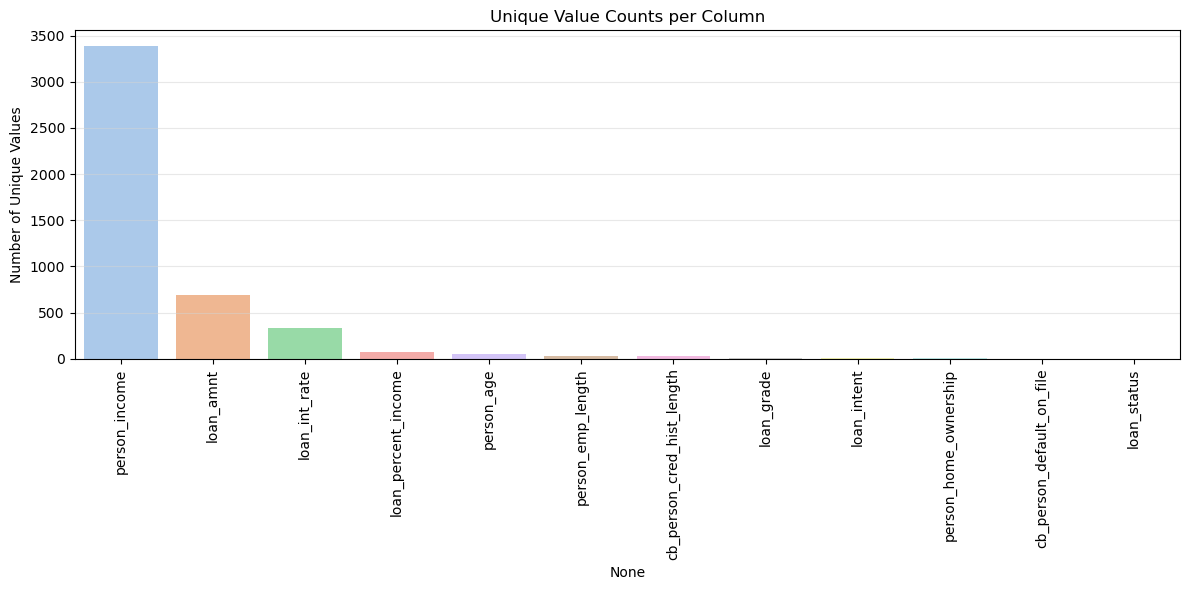

In [102]:
# Count unique values per column
unique_counts = train_credit_data_df.nunique().sort_values(ascending=False)

# Set plot size
plt.figure(figsize=(12, 6))

# Use seaborn's pastel palette with all different colors
palette = sns.color_palette("pastel", n_colors=len(unique_counts))

# Barplot
sns.barplot(x=unique_counts.index, y=unique_counts.values, palette=palette)

# Labels and title
plt.xticks(rotation=90)
plt.ylabel('Number of Unique Values')
plt.title('Unique Value Counts per Column')
plt.grid(True, axis='y', linestyle='-', color='lightgray', alpha=0.5)

# Tight layout and show
plt.tight_layout()
plt.show()


#### Numerical Columns: Distributions

In [103]:
train_credit_data_df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,22806.000000,2.280600e+04,22169.000000,22806.000000,20604.000000,22806.000000,22806.000000,22806.000000
mean,27.732088,6.620203e+04,4.773513,9565.708585,10.996065,0.169968,5.810576,0.218144
std,6.300267,6.638623e+04,4.166638,6302.955116,3.235314,0.106556,4.036588,0.412995
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,3.840000e+04,2.000000,5000.000000,7.900000,0.090000,3.000000,0.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.150000,4.000000,0.000000
75%,30.000000,7.920000e+04,7.000000,12000.000000,13.470000,0.230000,8.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.780000,30.000000,1.000000


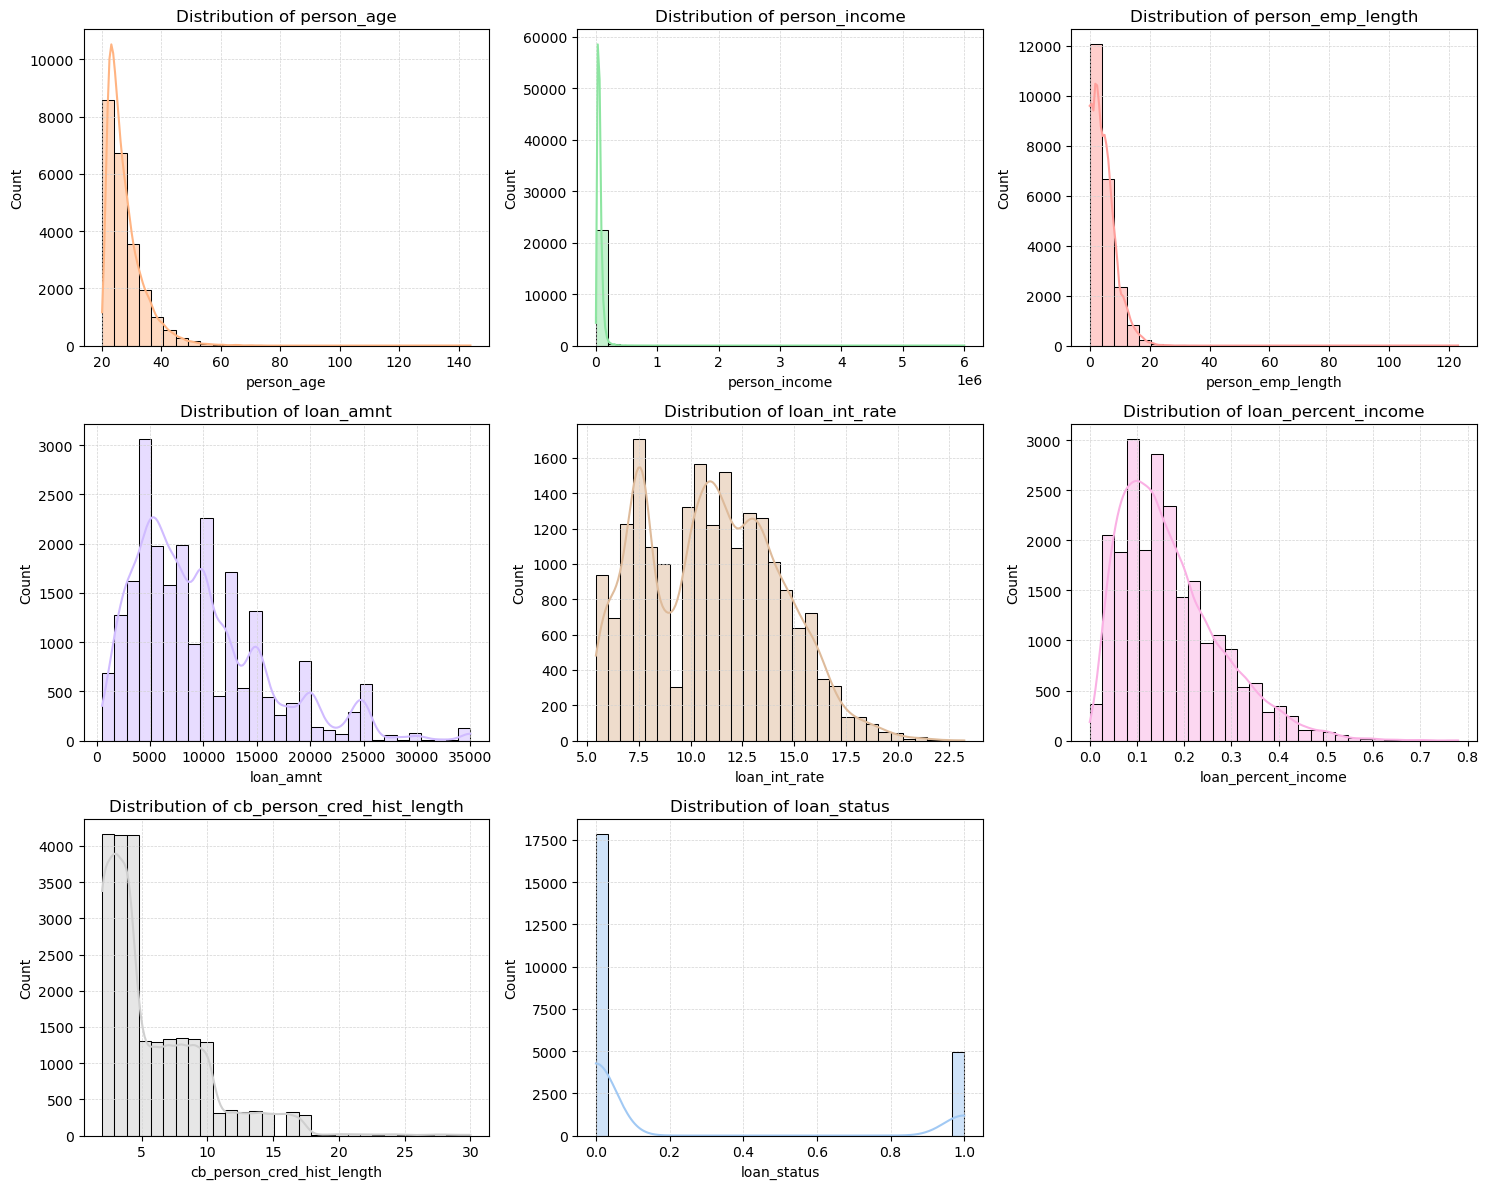

In [104]:

warnings.filterwarnings("ignore", category=FutureWarning)
# Select numeric columns
numeric_cols = train_credit_data_df.select_dtypes(include=['number']).columns

# Set up pastel color palette
colors = sns.color_palette("pastel", len(numeric_cols))

# Plot grid
n_cols = 3
n_rows = int(len(numeric_cols) / n_cols) + 1
plt.figure(figsize=(n_cols * 5, n_rows * 4))

# Loop through columns and plot
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    
    # Drop missing values
    data = train_credit_data_df[col].dropna()
    
    # Histogram
    sns.histplot(data, bins=30, color=colors[i % len(colors)], kde=True)
    
    # Formatting
    plt.title(f'Distribution of {col}', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.grid(True, linestyle='--', linewidth=0.5, color='lightgrey')

plt.tight_layout()
plt.show()

#### Pairwise Relationships of Predictors

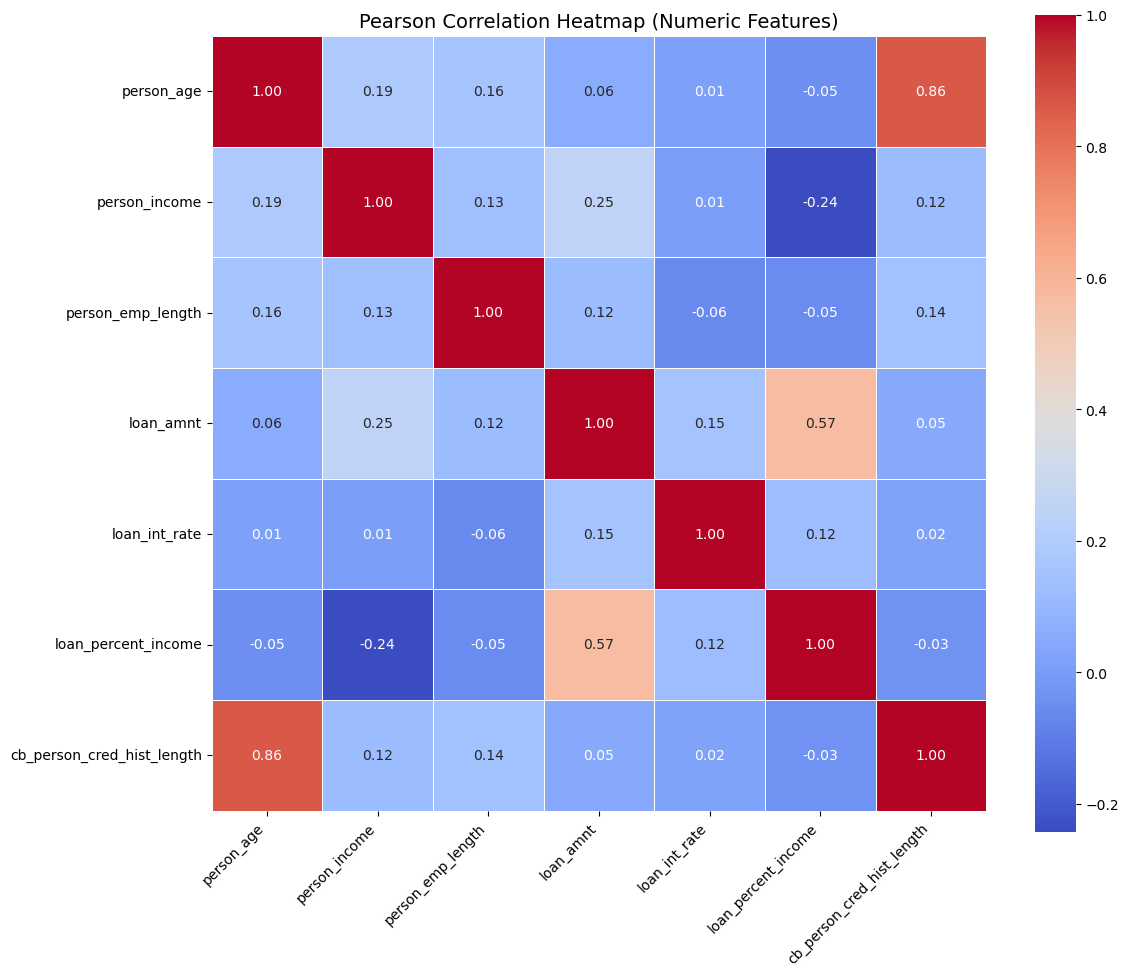

In [105]:
# Only numeric columns (excluding the target for now)
numeric_cols = train_credit_data_df.select_dtypes(include=['number']).drop(columns=['loan_status'], errors='ignore')

# ------------------------
# 1. Pearson Correlation
# ------------------------
# Compute full Pearson correlation matrix
corr_matrix = numeric_cols.corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",             # 2 decimal places
    cmap="coolwarm",       # Color gradient
    linewidths=0.5,        # Thin lines between cells
    square=True,           # Keep it square
    cbar=True # ,             # Show color bar
    # annot_kws={"size": 9, "color": "black"}  # Make annotations visible
)

plt.title("Pearson Correlation Heatmap (Numeric Features)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


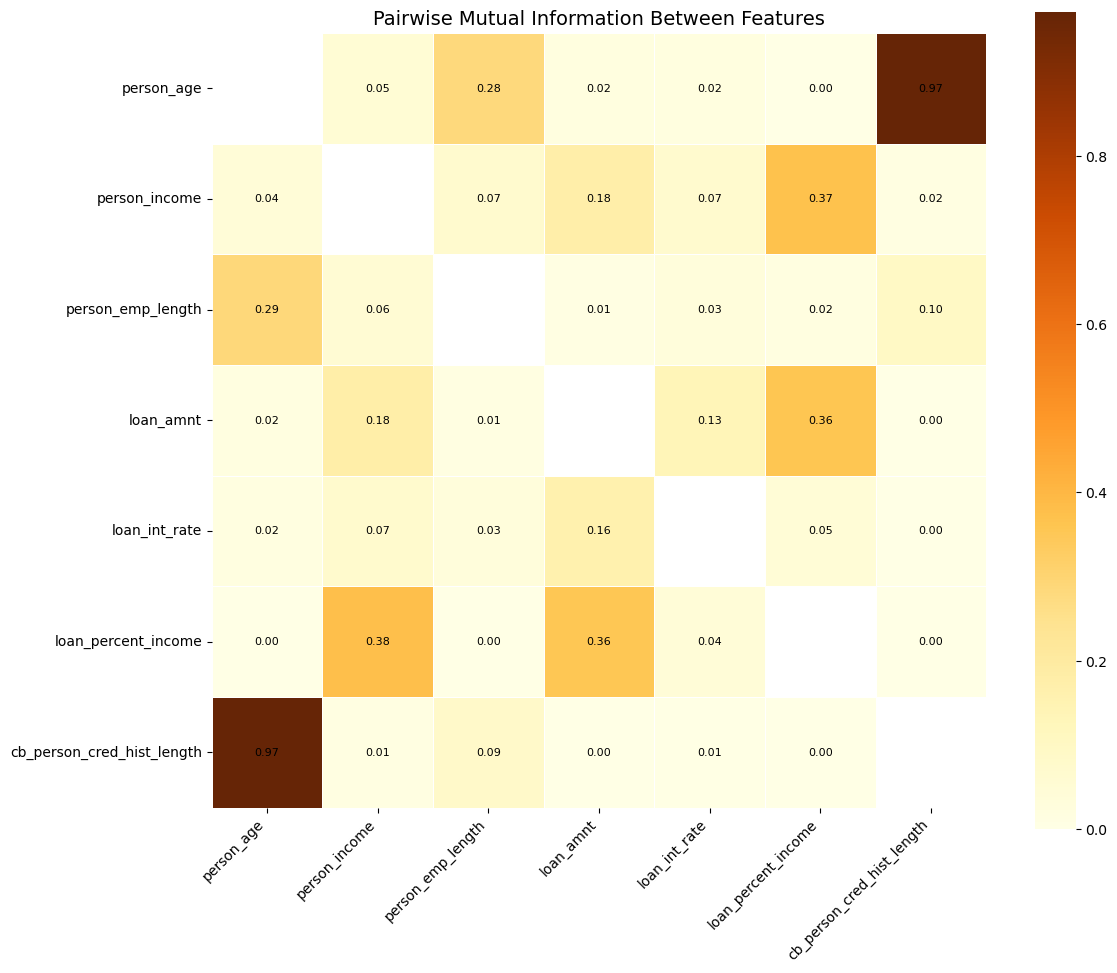

In [106]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Select only numeric features (excluding target)
features = train_credit_data_df.select_dtypes(include=['number']).drop(columns=['loan_status'], errors='ignore')

# Initialize empty DataFrame
mi_matrix = pd.DataFrame(index=features.columns, columns=features.columns)

# Compute MI for each pair
for target_col in features.columns:
    y = features[target_col]
    
    # Drop rows where y is NaN
    valid_idx = y.notna()
    y_clean = y[valid_idx]
    
    # Also drop the same rows in X, and exclude current feature
    X = features.drop(columns=[target_col]).loc[valid_idx]
    
    # Replace any remaining inf or NaN in X
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Compute mutual information
    mi = mutual_info_regression(X, y_clean, discrete_features='auto', random_state=42)
    
    # Assign to matrix
    mi_matrix.loc[target_col, X.columns] = mi

# Convert to float
mi_matrix = mi_matrix.astype(float)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    mi_matrix,
    cmap="YlOrBr",
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    annot_kws={"size": 8, "color": "black"}
)
plt.title("Pairwise Mutual Information Between Features", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### Categorical Columns

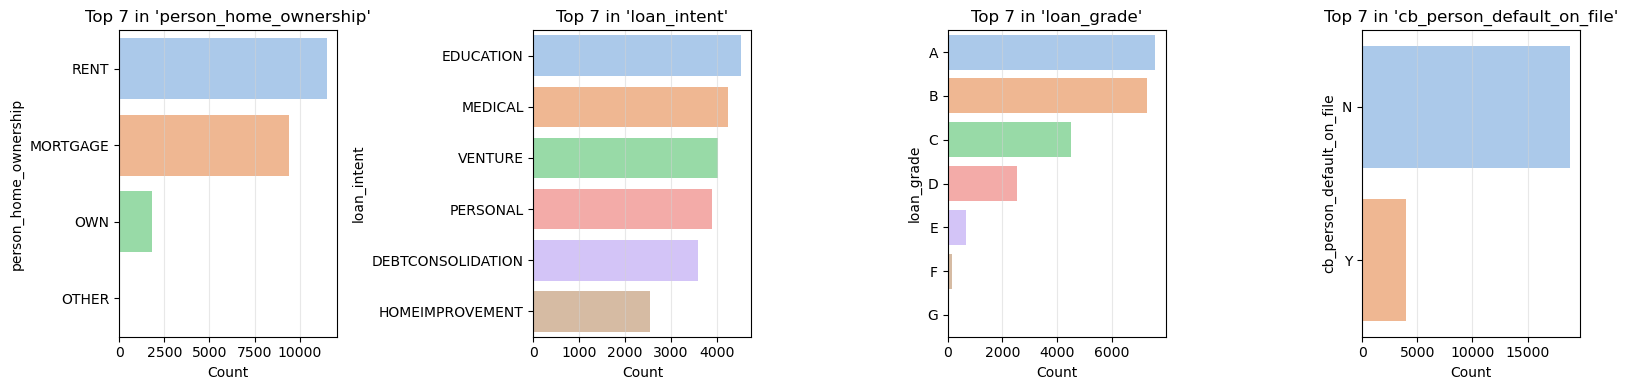

In [107]:
# Identify categorical columns (top 5 categories per col)
categorical_cols = train_credit_data_df.select_dtypes(include='object').columns

# Set number of columns per row
plots_per_row = 4

# Calculate rows needed
num_plots = len(categorical_cols)
num_rows = (num_plots + plots_per_row - 1) // plots_per_row

# Create subplots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(16, 4 * num_rows))
axes = axes.flatten()  # Flatten in case of single row

# Loop through and create each barplot
for i, col in enumerate(categorical_cols):
    top_values = train_credit_data_df[col].value_counts().nlargest(7)

    sns.barplot(
        x=top_values.values,
        y=top_values.index,
        palette='pastel',
        ax=axes[i]
    )

    axes[i].set_title(f"Top 7 in '{col}'")
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(col)
    axes[i].grid(True, axis='x', linestyle='-', color='lightgray', alpha=0.5)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Predictors vs Target

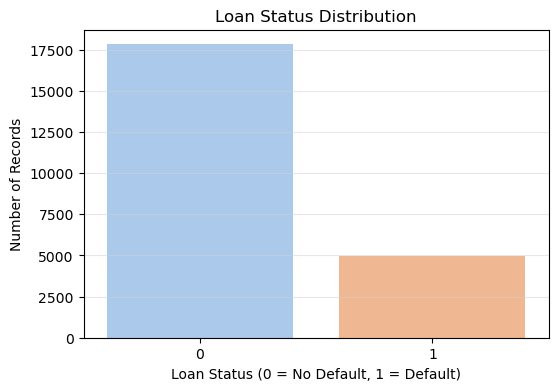

In [108]:
# Barplot of loan_status counts
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status', data=train_credit_data_df, palette='pastel')

# Labels and grid
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status (0 = No Default, 1 = Default)')
plt.ylabel('Number of Records')
plt.grid(True, axis='y', linestyle='-', color='lightgray', alpha=0.5)

plt.show()


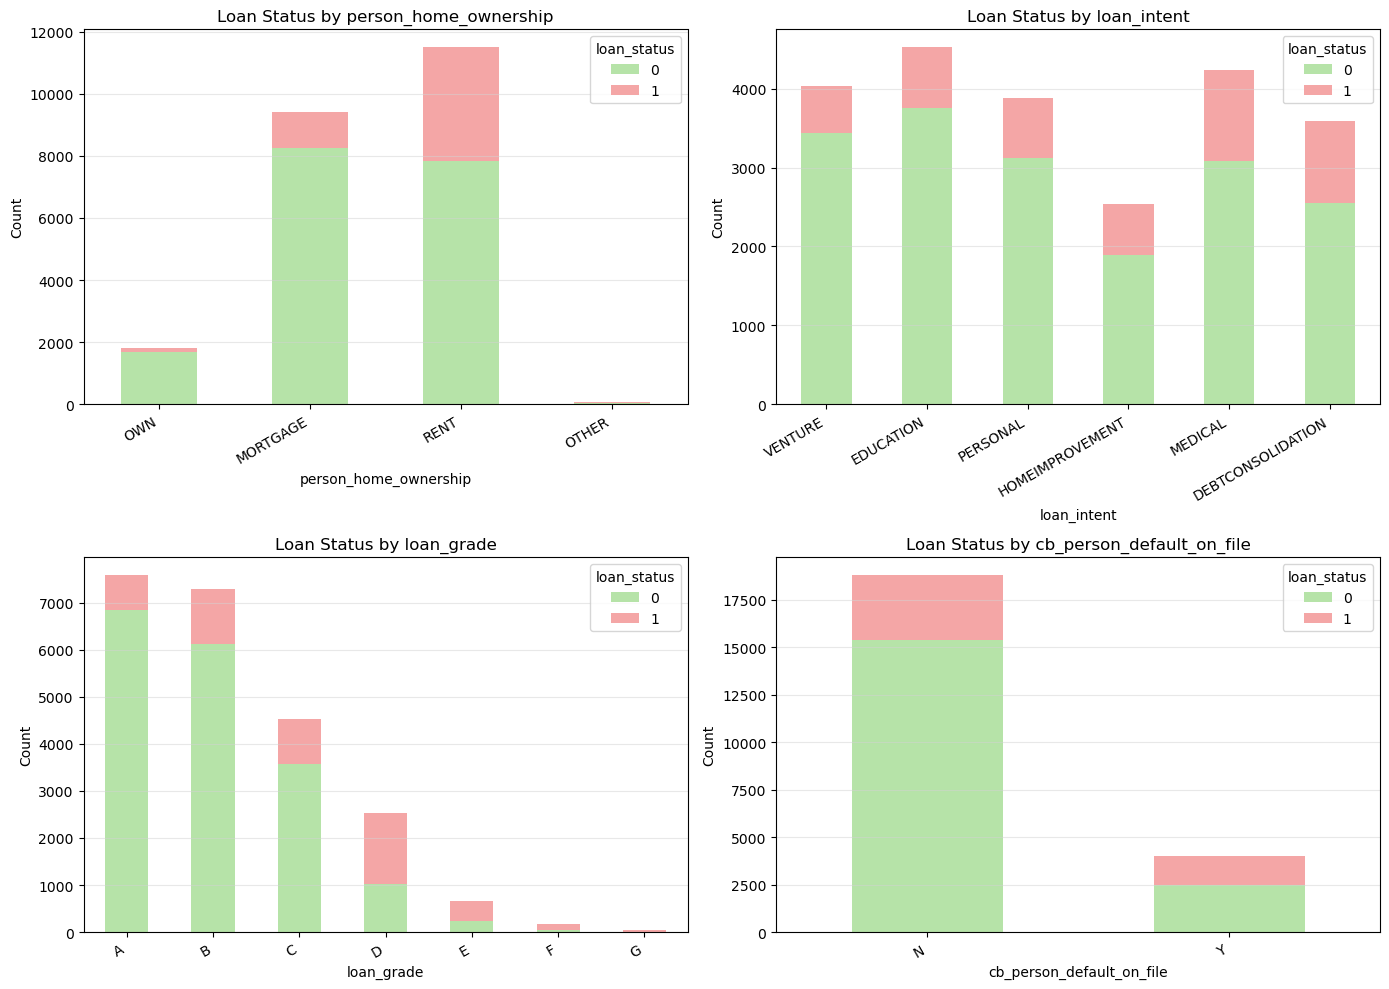

In [109]:
# Define pastel green and red for loan_status 0 and 1
colors = {0: '#b6e3a8', 1: '#f4a6a6'}  # pastel green & red

# Identify categorical columns
categorical_cols = train_credit_data_df.select_dtypes(include='object').columns

# Subplot layout
plots_per_row = 2
num_plots = len(categorical_cols)
num_rows = (num_plots + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(14, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    # Group and count
    group_df = train_credit_data_df.groupby([col, 'loan_status']).size().unstack(fill_value=0)

    # Ensure columns ordered [0, 1]
    if 0 not in group_df.columns:
        group_df[0] = 0
    if 1 not in group_df.columns:
        group_df[1] = 0
    group_df = group_df[[0, 1]]

    # Calculate default rate and sort
    group_df['default_rate'] = group_df[1] / (group_df[0] + group_df[1])
    group_df = group_df.sort_values(by='default_rate', ascending=True)
    group_df = group_df.drop(columns='default_rate')

    # Plot stacked bar chart
    group_df.plot(kind='bar', stacked=True, ax=axes[i],
                  color=[colors[0], colors[1]])

    # Styling
    axes[i].set_title(f"Loan Status by {col}")
    axes[i].set_ylabel('Count')
    axes[i].grid(True, axis='y', linestyle='-', color='lightgray', alpha=0.5)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30, ha='right')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


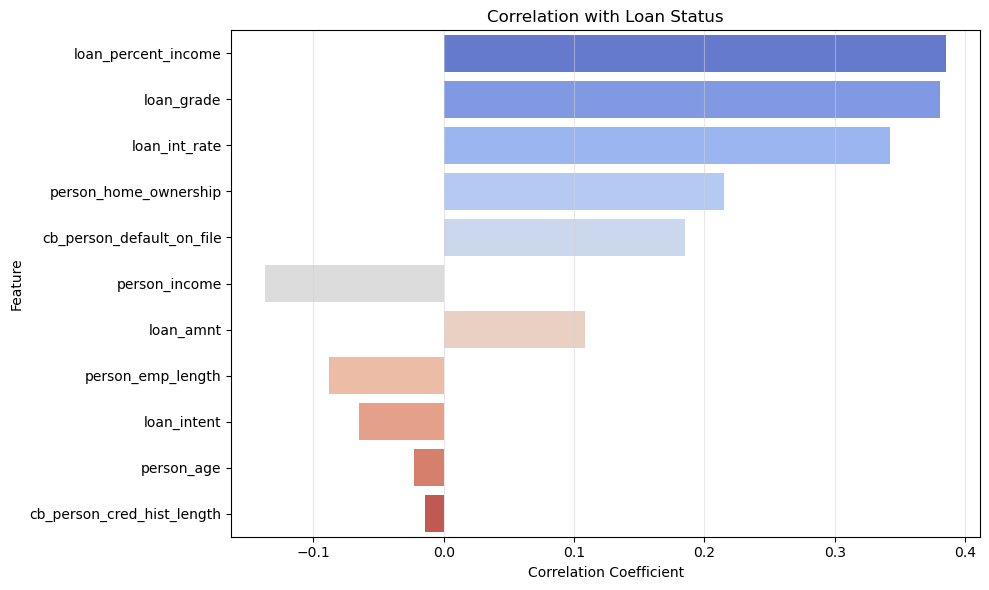

In [110]:
# 1. Copy dataframe to avoid changing original
df_corr = train_credit_data_df.copy()

# 2. Encode categorical variables numerically
categorical_cols = df_corr.select_dtypes(include='object').columns
df_corr[categorical_cols] = df_corr[categorical_cols].apply(lambda col: col.astype('category').cat.codes)

# 3. Compute correlation with target
correlations = df_corr.corr(numeric_only=True)['loan_status'].drop('loan_status')

# 4. Sort correlations
correlations = correlations.sort_values(key=abs, ascending=False)

# 5. Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')

plt.title("Correlation with Loan Status")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.grid(True, axis='x', linestyle='-', color='lightgray', alpha=0.5)

plt.tight_layout()
plt.show()


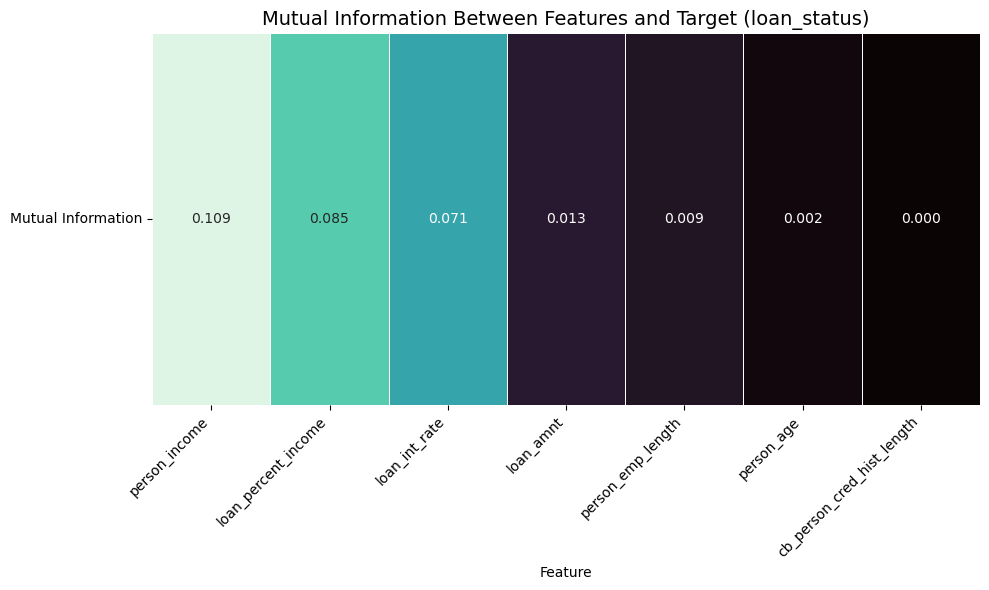

In [111]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -------------------------------
# Mutual Information vs loan_status
# -------------------------------

# Check if target column exists
if 'loan_status' in train_credit_data_df.columns:

    # Define target and features
    X = numeric_cols.copy()
    y = train_credit_data_df['loan_status']

    # Compute mutual information scores
    mi_scores = mutual_info_classif(X.fillna(0), y, discrete_features='auto', random_state=42)

    # Create a sorted DataFrame
    mi_df = pd.DataFrame({
        'Feature': X.columns,
        'Mutual Information': mi_scores
    }).sort_values(by='Mutual Information', ascending=False).set_index('Feature')

    # Plot the mutual information scores
    plt.figure(figsize=(10, 6))
    sns.heatmap(mi_df.T, 
                annot=True, 
                cmap="mako",         # 🔁 Changed here
                cbar=False, 
                linewidths=0.5, 
                fmt=".3f")

    plt.title("Mutual Information Between Features and Target (loan_status)", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ Target column 'loan_status' not found in dataset.")


In [112]:
def plot_mean_heatmap(df, row_var, col_var, value_var):
    """
    Create a heatmap showing the mean of `value_var` across combinations of `row_var` and `col_var`.

    Parameters:
    df        : DataFrame
    row_var   : str, column name for Y-axis (rows)
    col_var   : str, column name for X-axis (columns)
    value_var : str, column name for values to average (e.g., loan_status)
    """

    # Create pivot table of means
    pivot = df.pivot_table(
        index=row_var,
        columns=col_var,
        values=value_var,
        aggfunc='mean'
    )

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot,
                annot=True,
                fmt=".2f",
                cmap="Reds",
                linewidths=0.5,
                linecolor='gray',
                cbar_kws={'label': f'Mean {value_var}'})

    plt.title(f"Mean {value_var} by {row_var} and {col_var}", fontsize=14)
    plt.xlabel(col_var)
    plt.ylabel(row_var)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

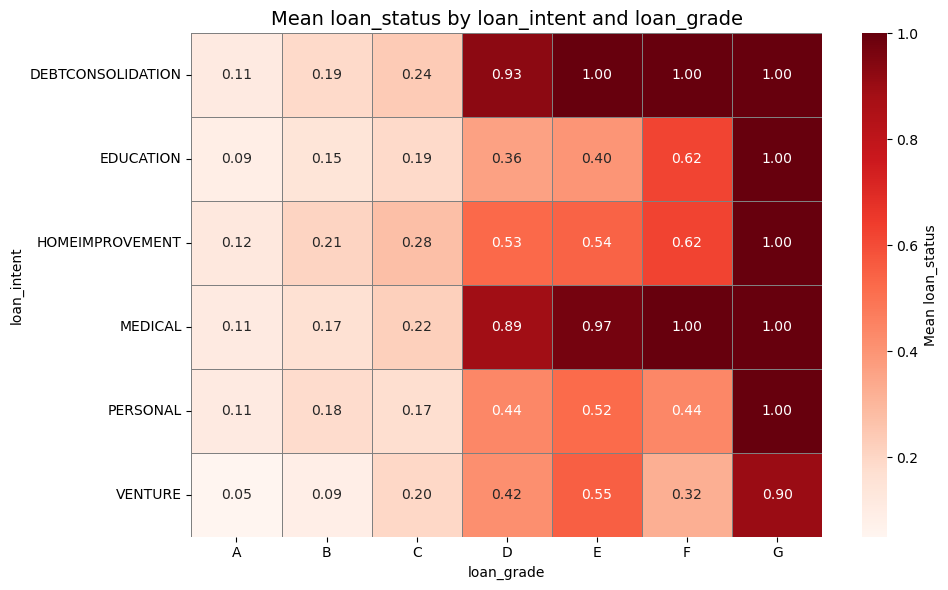

In [113]:
plot_mean_heatmap(train_credit_data_df, 'loan_intent', 'loan_grade', 'loan_status')


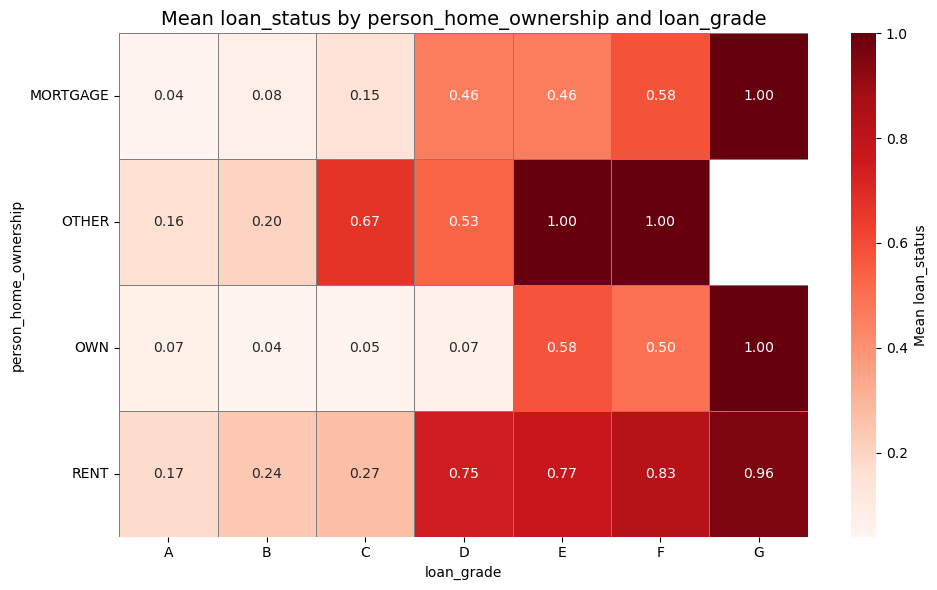

In [114]:
plot_mean_heatmap(train_credit_data_df, 'person_home_ownership', 'loan_grade', 'loan_status')


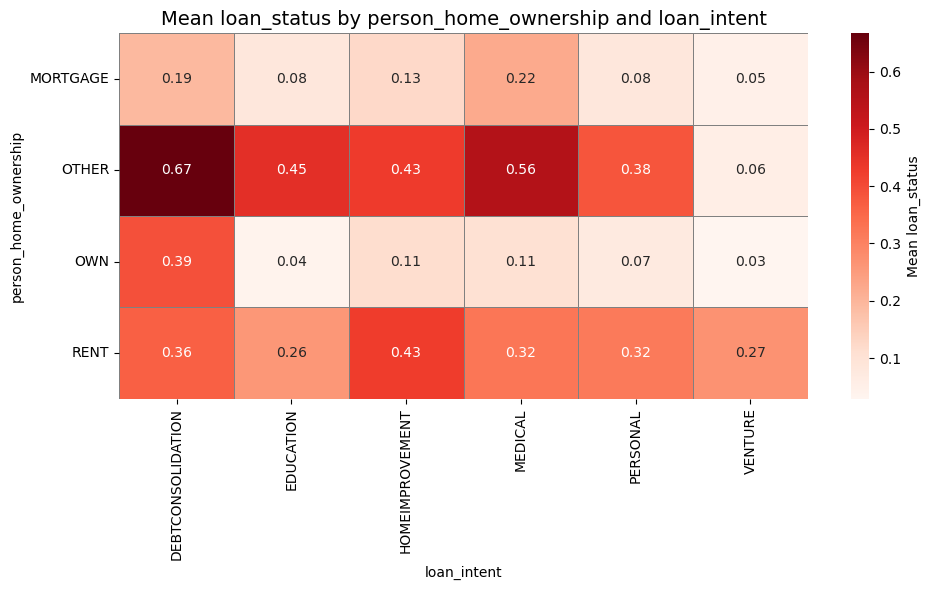

In [115]:
plot_mean_heatmap(train_credit_data_df, 'person_home_ownership', 'loan_intent', 'loan_status')


#### Outliers

In [116]:
def detect_outliers_iqr(df, numeric_cols):
    """
    Detects outliers in each numerical column using the IQR method.
    
    Parameters:
    df           : DataFrame
    numeric_cols : list of numerical column names

    Returns:
    outlier_summary : DataFrame showing count and % of outliers per column
    """
    outlier_info = []

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = outliers.shape[0]
        outlier_pct = 100 * outlier_count / df.shape[0]

        outlier_info.append({
            'Feature': col,
            'Outlier Count': outlier_count,
            'Outlier %': round(outlier_pct, 2)
        })

    return pd.DataFrame(outlier_info).sort_values(by='Outlier %', ascending=False)

In [117]:
numeric_cols = train_credit_data_df.select_dtypes(include=['float', 'int']).columns.drop('loan_status')

outlier_summary = detect_outliers_iqr(train_credit_data_df, numeric_cols)
outlier_summary


,Feature,Outlier Count,Outlier %
3,loan_amnt,1223,5.36
1,person_income,1064,4.67
0,person_age,1057,4.63
6,cb_person_cred_hist_length,799,3.50
2,person_emp_length,596,2.61
5,loan_percent_income,446,1.96
4,loan_int_rate,5,0.02


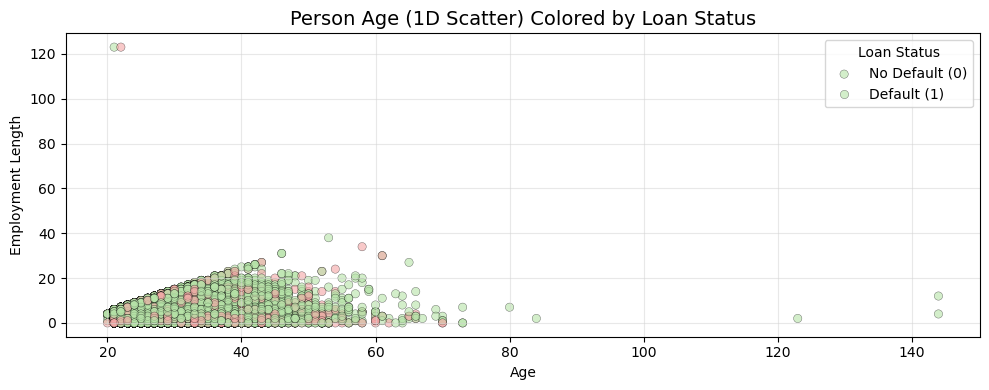

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set color palette: 0 = green, 1 = red
palette = {0: '#b6e3a8', 1: '#f4a6a6'}

plt.figure(figsize=(10, 4))

# Scatter plot: X = Y = person_age
sns.scatterplot(
    x=train_credit_data_df['person_age'],
    y=train_credit_data_df['person_emp_length'],
    hue=train_credit_data_df['loan_status'],
    palette=palette,
    alpha=0.6,
    edgecolor='black',
    linewidth=0.3
)

plt.title("Person Age (1D Scatter) Colored by Loan Status", fontsize=14)
plt.xlabel("Age")
plt.ylabel("Employment Length")
plt.grid(True, linestyle='-', color='lightgray', alpha=0.5)
plt.legend(title='Loan Status', labels=['No Default (0)', 'Default (1)'])
plt.tight_layout()
plt.show()


#### Assess Loaded dataset

In [119]:
X_test

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
25630,29,90444,RENT,13.0,MEDICAL,A,12000,7.14,0.13,N,8
477,22,43385,RENT,7.0,PERSONAL,C,23000,NaN,0.53,N,3
6632,26,45928,RENT,5.0,HOMEIMPROVEMENT,A,6000,7.90,0.13,N,4
8165,25,53600,RENT,1.0,EDUCATION,A,7300,8.00,0.14,N,4
6073,23,12000,RENT,0.0,PERSONAL,A,5825,6.62,0.49,N,4
...,...,...,...,...,...,...,...,...,...,...,...
18407,30,75000,RENT,7.0,MEDICAL,B,20000,12.18,0.27,N,7
9407,22,72000,RENT,0.0,MEDICAL,A,8000,7.90,0.11,N,4
20800,28,44000,RENT,7.0,DEBTCONSOLIDATION,A,5000,5.42,0.11,N,7
31721,44,58000,RENT,2.0,HOMEIMPROVEMENT,C,15000,13.48,0.26,Y,15


In [120]:
train_credit_data_df = train_credit_data_df.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [121]:
datasets_scores = {}
evaluate_dataset(train_credit_data_df, X_test, 'LOADED') 

Fold: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]

---------- BASE ROC_AUC: 0.9464807634155297 ----------:



,Model,Dataset,Mean OOF ROC_AUC,ROC_AUC,Accuracy Score,Precision Score,Recall Score,f1 Score,Matthews Corr Coef,iteration_time
0,BASE,LOADED,0.94657,0.946481,0.9381,0.9404,0.9381,0.9348,0.8131,0.662907


#### Assess Cleaned Dataset

In [122]:
# -----------------------------------------------
# Remove rows with unrealistic values in 'person_age' and 'person_emp_length'
# These thresholds (age > 100, emp_length > 100) likely indicate data errors or extreme outliers
# -----------------------------------------------

train_credit_data_df_cleaned = train_credit_data_df.drop(train_credit_data_df[train_credit_data_df['person_age'] > 100].index)
train_credit_data_df_cleaned = train_credit_data_df_cleaned.drop(train_credit_data_df_cleaned[train_credit_data_df_cleaned['person_emp_length'] > 100].index)

# Reset index after dropping rows
train_credit_data_df_cleaned = train_credit_data_df_cleaned.reset_index(drop=True)

X_test


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,29,90444,RENT,13.0,MEDICAL,A,12000,7.14,0.13,N,8
1,22,43385,RENT,7.0,PERSONAL,C,23000,NaN,0.53,N,3
2,26,45928,RENT,5.0,HOMEIMPROVEMENT,A,6000,7.90,0.13,N,4
3,25,53600,RENT,1.0,EDUCATION,A,7300,8.00,0.14,N,4
4,23,12000,RENT,0.0,PERSONAL,A,5825,6.62,0.49,N,4
...,...,...,...,...,...,...,...,...,...,...,...
9770,30,75000,RENT,7.0,MEDICAL,B,20000,12.18,0.27,N,7
9771,22,72000,RENT,0.0,MEDICAL,A,8000,7.90,0.11,N,4
9772,28,44000,RENT,7.0,DEBTCONSOLIDATION,A,5000,5.42,0.11,N,7
9773,44,58000,RENT,2.0,HOMEIMPROVEMENT,C,15000,13.48,0.26,Y,15


In [123]:
X_test_cleaned = X_test.drop(X_test[X_test['person_age'] > 100].index)
X_test_cleaned = X_test_cleaned.drop(X_test_cleaned[X_test_cleaned['person_emp_length'] > 100].index)

# Reset index after dropping rows
X_test_cleaned = X_test_cleaned.reset_index(drop=True)

In [124]:
evaluate_dataset(train_credit_data_df_cleaned, X_test_cleaned, 'CLEANED') 

Fold: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]

---------- BASE ROC_AUC: 0.9458685134652851 ----------:



,Model,Dataset,Mean OOF ROC_AUC,ROC_AUC,Accuracy Score,Precision Score,Recall Score,f1 Score,Matthews Corr Coef,iteration_time
0,BASE,CLEANED,0.946026,0.945869,0.9375,0.9396,0.9375,0.9342,0.811,0.682363


#### Feature Engineering

1. Income is very skewed -> Log-tranformation
2. New feature of amount/income 

In [125]:
def add_interaction_features(df):
    """
    Adds interaction features and a log-transformed income column.
    Assumes columns: person_income, loan_amnt, loan_int_rate, person_emp_length, person_age
    """
    df = df.copy()
    # Income to loan amount ratio
    df['loan_to_income_ratio'] = df['loan_amnt'] / (df['person_income'] + 1e-6)
    # Income to interest rate ratio
    # df['interest_to_income_ratio'] = df['loan_int_rate'] / (df['person_income'] + 1e-6)
    # Employment length to age ratio
    # df['emp_length_to_age_ratio'] = df['person_emp_length'] / (df['person_age'] + 1e-6)
    # Log-transformed income
    df['log_income'] = np.log1p(df['person_income'])  # log(1 + income)

    return df


In [126]:
train_credit_data_df_cleaned_fe, X_test_cleaned_fe = add_interaction_features(train_credit_data_df_cleaned), add_interaction_features(X_test_cleaned)


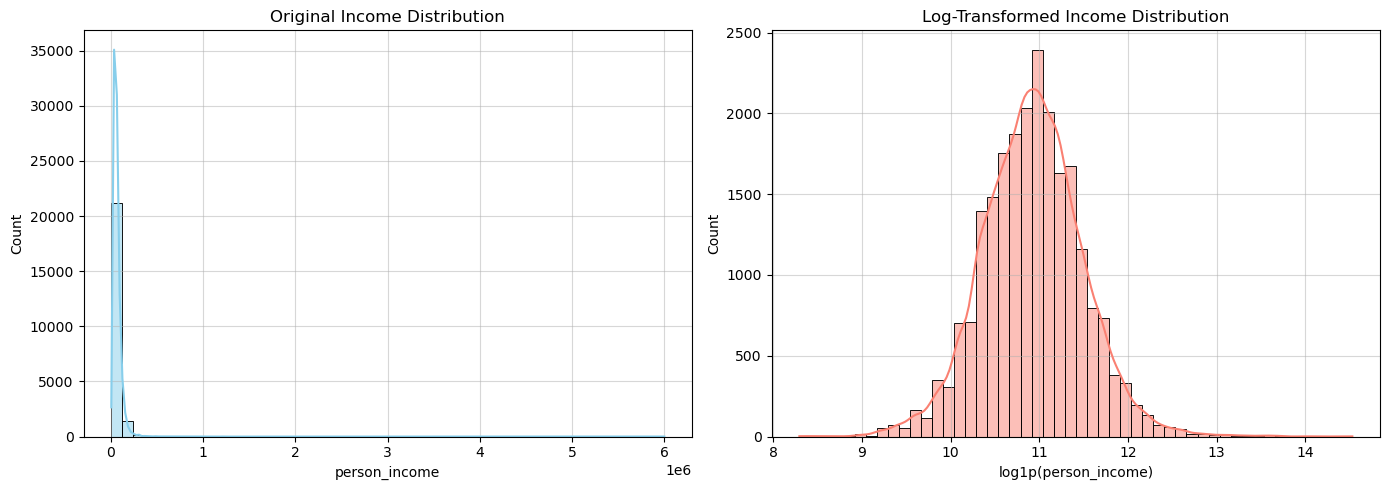

In [127]:
# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw income distribution
sns.histplot(train_credit_data_df['person_income'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Original Income Distribution')
axes[0].set_xlabel('person_income')
axes[0].grid(True, linestyle='-', alpha=0.5)

# Log-transformed income distribution
sns.histplot(train_credit_data_df_cleaned_fe['log_income'], bins=50, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Log-Transformed Income Distribution')
axes[1].set_xlabel('log1p(person_income)')
axes[1].grid(True, linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

In [128]:
evaluate_dataset(train_credit_data_df_cleaned_fe, X_test_cleaned_fe, 'CLEANED+FE') 

Fold: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

---------- BASE ROC_AUC: 0.9472515508872987 ----------:



,Model,Dataset,Mean OOF ROC_AUC,ROC_AUC,Accuracy Score,Precision Score,Recall Score,f1 Score,Matthews Corr Coef,iteration_time
0,BASE,CLEANED+FE,0.947415,0.947252,0.9378,0.9398,0.9378,0.9345,0.8118,0.717685


**Composite risk encoding**: Group-based mean target encoding to pre-calculate historical default rates. For example, Grade A + debt consolidation + home ownership = 1% default.

In [129]:
def apply_composite_target_encoding(train_df, test_df, target_col, cat_cols, fill_value=0.3333):
    """
    Performs composite group-based target encoding on multiple categorical columns.
    
    Parameters:
    - train_df: DataFrame with target column
    - test_df: DataFrame without target column
    - target_col: string, name of the target variable
    - cat_cols: list of strings, categorical columns to group by (e.g. ['grade', 'intent', 'home_ownership'])
    - fill_value: value to assign when a group in test data is not seen in train

    Returns:
    - train_df_encoded, test_df_encoded: copies of input DataFrames with new 'alpha' feature
    """

    train = train_df.copy()
    test = test_df.copy()

    # Step 1: Create composite key from categorical columns
    group_key_name = '_'.join(cat_cols)
    train['group_key'] = train[cat_cols].astype(str).agg('-'.join, axis=1)
    test['group_key'] = test[cat_cols].astype(str).agg('-'.join, axis=1)

    # Step 2: Calculate mean target value for each group in training set
    group_means = train.groupby('group_key')[target_col].mean().to_dict()

    train['group_key'] = train['group_key'].astype('category')
    test['group_key'] = test['group_key'].astype('category')

    # Step 3: Map the group-level means to both datasets
    train['alpha'] = train['group_key'].map(group_means).fillna(fill_value)
    test['alpha'] = test['group_key'].map(group_means).fillna(fill_value)

    # Step 4: Drop temporary key column (optional, keep if debugging)
    # train.drop(columns=['group_key'], inplace=True)
    # test.drop(columns=['group_key'], inplace=True)

    return train, test

In [130]:
# Define the columns to group on
categorical_group = ['loan_grade', 'loan_intent', 'person_home_ownership']

# Apply the composite encoding
train_credit_data_df_cleaned_fA, X_test_df_cleaned_fA = apply_composite_target_encoding(
    train_df=train_credit_data_df_cleaned,
    test_df=X_test_cleaned,
    target_col=TARGET,
    cat_cols=categorical_group,
    fill_value=0.25  # fallback for unseen groups - for reference overall mean is .22
)


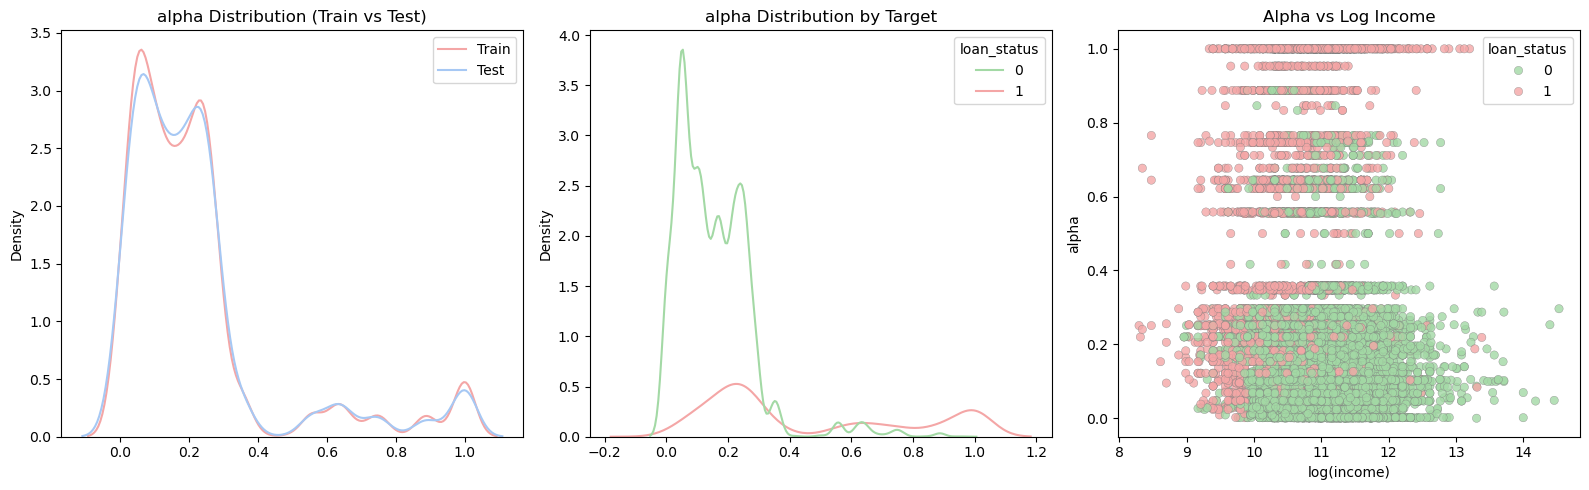

In [131]:
# train_credit_data_df_cleaned = add_interactiodatures(train_credit_data_df_cleaned)

# Make sure color variables exist
green = '#A3D9A5'
red = '#F4A6A6'
blue = '#A6C8F4'

# Ensure log_income exists
if 'log_income' not in train_credit_data_df_cleaned_fA.columns:
    train_credit_data_df_cleaned_fA['log_income'] = np.log1p(train_credit_data_df_cleaned_fA['person_income'])

# Set up the plots
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
ax = ax.flatten()

# Column to plot
column = 'alpha'
i = 0

# KDE: Train vs Test
sns.kdeplot(train_credit_data_df_cleaned_fA[column], label='Train', ax=ax[i], color=red)
sns.kdeplot(X_test_df_cleaned_fA[column], label='Test', ax=ax[i], color=blue)
ax[i].legend()
ax[i].set_title(f'{column} Distribution (Train vs Test)')
ax[i].set_xlabel(None)

# KDE by TARGET
i = 1
sns.kdeplot(data=train_credit_data_df_cleaned_fA, x=column, label='alpha', hue=TARGET, ax=ax[i], palette={0: green, 1: red})
ax[i].set_title(f'{column} Distribution by Target')
ax[i].set_xlabel(None)

# Scatter plot: log_income vs alpha
i = 2
sns.scatterplot(data=train_credit_data_df_cleaned_fA, x='log_income', y=column, hue=TARGET, palette={0: green, 1: red}, alpha=0.8, edgecolor='gray', linewidth=0.3)
ax[i].set_title(f'Alpha vs Log Income')
ax[i].set_xlabel('log(income)')
ax[i].set_ylabel('alpha')

plt.tight_layout()
plt.show()


In [132]:
train_credit_data_df_cleaned_fA.drop(['alpha'], axis=1, inplace=True)
X_test_df_cleaned_fA.drop(['alpha'], axis=1, inplace=True)

In [133]:
evaluate_dataset(train_credit_data_df_cleaned_fA, X_test_df_cleaned_fA, 'CLEANED+f_A') 

Fold: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

---------- BASE ROC_AUC: 0.9429246362794051 ----------:



,Model,Dataset,Mean OOF ROC_AUC,ROC_AUC,Accuracy Score,Precision Score,Recall Score,f1 Score,Matthews Corr Coef,iteration_time
0,BASE,CLEANED+f_A,0.943097,0.942925,0.9356,0.9371,0.9356,0.9323,0.8046,0.746665


**New feature**: job stability + earning capacity.

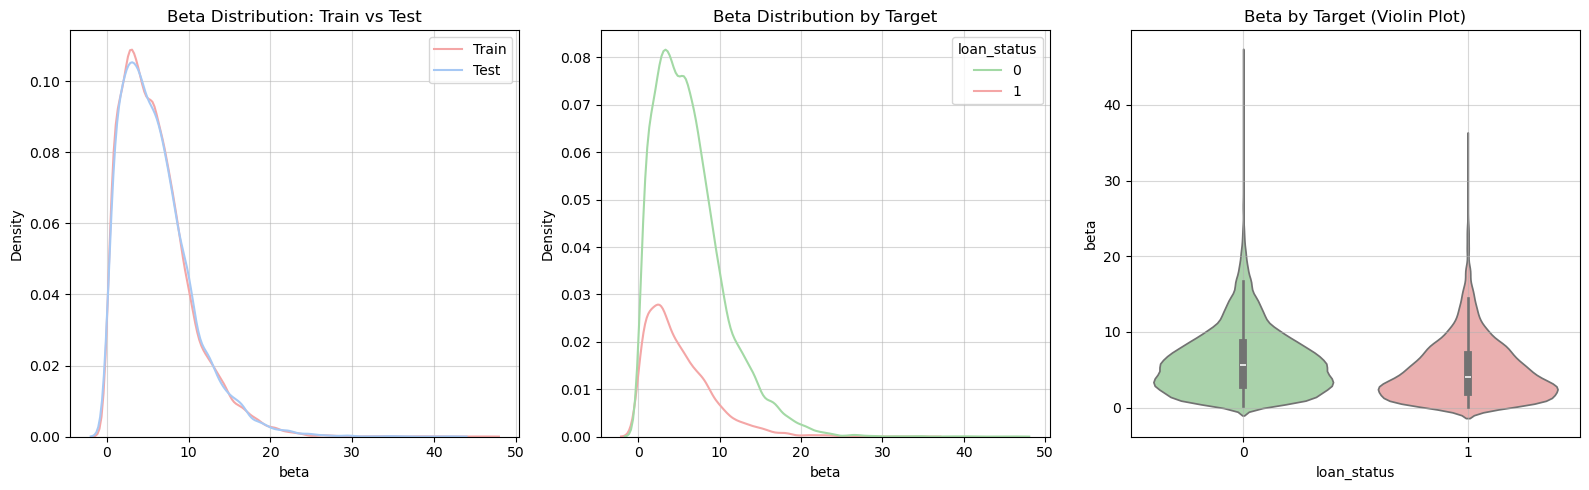

In [137]:
# Define color palette
green = '#A3D9A5'
red = '#F4A6A6'
blue = '#A6C8F4'

# Create copies to avoid mutating originals
train_b = train_credit_data_df_cleaned_fe.copy()
test_b = X_test_cleaned_fe.copy()

# -------------------------------------------
# STEP 1: Scale income to match emp_length range
# -------------------------------------------
income_max = train_b['person_income'].max()
emp_length_max = train_b['person_emp_length'].max()

# Scale factor to put income and emp_length on similar scales
scale_factor = emp_length_max / income_max

# -------------------------------------------
# STEP 2: Create composite feature 'beta'
# -------------------------------------------
train_b['beta'] = scale_factor * train_b['person_income'] + train_b['person_emp_length']
test_b['beta'] = scale_factor * test_b['person_income'] + test_b['person_emp_length']

# -------------------------------------------
# STEP 3: Visualize 'beta'
# -------------------------------------------
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
ax = ax.flatten()

# Plot 1: Train vs Test distribution of 'beta'
sns.kdeplot(train_b['beta'], label='Train', ax=ax[0], color=red)
sns.kdeplot(test_b['beta'], label='Test', ax=ax[0], color=blue)
ax[0].set_title("Beta Distribution: Train vs Test")
ax[0].set_xlabel("beta")
ax[0].legend()
ax[0].grid(True, linestyle='-', alpha=0.5)

# Plot 2: Train distribution by TARGET
sns.kdeplot(data=train_b, x='beta', hue=TARGET, ax=ax[1], palette={0: green, 1: red})
ax[1].set_title("Beta Distribution by Target")
ax[1].set_xlabel("beta")
ax[1].grid(True, linestyle='-', alpha=0.5)

# Plot 3: Violin plot by TARGET
sns.violinplot(data=train_b, y='beta', x=TARGET, palette={'0': green, '1': red}, ax=ax[2])
ax[2].set_title("Beta by Target (Violin Plot)")
ax[2].set_xlabel(TARGET)
ax[2].set_ylabel("beta")
ax[2].grid(True, linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

In [138]:
evaluate_dataset(train_b, test_b, 'FE B')

Fold: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

---------- BASE ROC_AUC: 0.9456750240082783 ----------:



,Model,Dataset,Mean OOF ROC_AUC,ROC_AUC,Accuracy Score,Precision Score,Recall Score,f1 Score,Matthews Corr Coef,iteration_time
0,BASE,FE B,0.945894,0.945675,0.937,0.9392,0.937,0.9337,0.8095,0.774631


#### Impute missing values

In [140]:
# Step 1: Define the fcn and impute functions

def fcn(df):
    """
    Splits DataFrame into all columns, categorical columns, and numeric columns.
    """
    return (
        df.columns.tolist(),
        df.select_dtypes(include=['object', 'category']).columns.tolist(),
        df.select_dtypes(exclude=['object', 'category']).columns.tolist()
    )

def impute(df_):
    """
    Fills missing values:
    - Categorical: 'none' and convert to category dtype
    - Numeric: fill with 0
    """
    df = df_.copy()
    _, category_columns, nums = fcn(df)

    # Fill missing categorical with 'none' and cast to category
    df[category_columns] = df[category_columns] \
        .astype('object') \
        .fillna('none') \
        .astype('category')

    # Fill missing numeric values with 0
    df[nums] = df[nums].fillna(0)

    return df


In [141]:
# Apply imputation to cleaned feature-engineered train and test data
train_imputed = impute(train_credit_data_df_cleaned_fe)
test_imputed = impute(X_test_cleaned_fe)

In [142]:
evaluate_dataset(train_imputed, test_imputed, 'IMPUTED')

Fold: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]

---------- BASE ROC_AUC: 0.9472580918842716 ----------:



,Model,Dataset,Mean OOF ROC_AUC,ROC_AUC,Accuracy Score,Precision Score,Recall Score,f1 Score,Matthews Corr Coef,iteration_time
0,BASE,IMPUTED,0.947434,0.947258,0.9374,0.9394,0.9374,0.9341,0.8106,0.702016


#### Encoding: Ordinal

In [148]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

# Make copies
train_encoded = train_imputed.copy()
test_encoded = test_imputed.copy()

# Step 1: Identify categorical columns
category_columns = train_encoded.select_dtypes(include=['object', 'category']).columns.tolist()

# Step 2: Combine for consistent encoding
combined_cat = pd.concat([train_encoded[category_columns], test_encoded[category_columns]], axis=0)

# Step 3: Fit encoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(combined_cat)

# Step 4: Transform and convert back to DataFrame
train_cat_encoded = pd.DataFrame(
    encoder.transform(train_encoded[category_columns]),
    columns=category_columns,
    index=train_encoded.index
)

test_cat_encoded = pd.DataFrame(
    encoder.transform(test_encoded[category_columns]),
    columns=category_columns,
    index=test_encoded.index
)

# Step 5: Cast to int32 → category
for col in category_columns:
    train_encoded[col] = train_cat_encoded[col].astype('int32').astype('category')
    test_encoded[col] = test_cat_encoded[col].astype('int32').astype('category')


In [149]:
evaluate_dataset(train_encoded, test_encoded, 'ORD_ENCODED')

Fold: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

---------- BASE ROC_AUC: 0.9472580918842716 ----------:



,Model,Dataset,Mean OOF ROC_AUC,ROC_AUC,Accuracy Score,Precision Score,Recall Score,f1 Score,Matthews Corr Coef,iteration_time
0,BASE,ORD_ENCODED,0.947434,0.947258,0.9374,0.9394,0.9374,0.9341,0.8106,0.686028


#### Encoding: One-hot

In [152]:
from sklearn.preprocessing import OneHotEncoder

def onehot(train_, test_, target_col='TARGET'):
    """
    Performs one-hot encoding on categorical columns using combined train/test fitting.
    Preserves numeric columns and target variable in train set.
    """
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

    # Copy input data
    train = train_.copy()
    test = test_.copy()

    # Identify categorical and numeric columns
    _, cat_cols, num_cols = fcn(test)

    # Separate numeric features
    train_num = train[num_cols]
    test_num = test[num_cols]

    # Fit encoder on combined categories for consistency
    encoder.fit(train[cat_cols])

    # Transform categorical features and convert to DataFrames
    train_cat_encoded = pd.DataFrame(
        encoder.transform(train[cat_cols]),
        columns=encoder.get_feature_names_out(cat_cols),
        index=train.index
    ).astype(int).astype('category')

    test_cat_encoded = pd.DataFrame(
        encoder.transform(test[cat_cols]),
        columns=encoder.get_feature_names_out(cat_cols),
        index=test.index
    ).astype(int).astype('category')

    # Combine numeric and encoded categorical features
    train_oh = pd.concat([train_num, train_cat_encoded], axis=1)
    test_oh = pd.concat([test_num, test_cat_encoded], axis=1)

    # Ensure column names are strings
    train_oh.columns = train_oh.columns.astype(str)
    test_oh.columns = test_oh.columns.astype(str)

    # Restore target column to train
    if target_col in train:
        train_oh[target_col] = train[target_col]

    return train_oh, test_oh


In [153]:
train_oh, test_oh = onehot(train_imputed, test_imputed, target_col=TARGET)

In [155]:
evaluate_dataset(train_oh, test_oh, 'OH_ENCODED')

Fold: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]

---------- BASE ROC_AUC: 0.9481952250316106 ----------:



,Model,Dataset,Mean OOF ROC_AUC,ROC_AUC,Accuracy Score,Precision Score,Recall Score,f1 Score,Matthews Corr Coef,iteration_time
0,BASE,OH_ENCODED,0.948309,0.948195,0.9382,0.9403,0.9382,0.9349,0.8131,0.848171


#### Scaling

In [160]:
train_encoded[TARGET] = train_encoded[TARGET].astype('category')
train_encoded.dtypes

person_age                       int64
person_income                    int64
person_home_ownership         category
person_emp_length              float64
loan_intent                   category
loan_grade                    category
loan_amnt                        int64
loan_int_rate                  float64
loan_percent_income            float64
cb_person_default_on_file     category
cb_person_cred_hist_length       int64
loan_status                   category
loan_to_income_ratio           float64
log_income                     float64
dtype: object

In [161]:
from sklearn.preprocessing import StandardScaler

# Step 1: Copy the encoded datasets
train_scaled = train_encoded.copy()
test_scaled = test_encoded.copy()

# Step 2: Get features from the TRAIN set only (to avoid leakage)
_, cat_cols, num_cols = fcn(train_scaled)

# Step 3: Fit StandardScaler on train, then apply to both
scaler = StandardScaler()

train_scaled[num_cols] = scaler.fit_transform(train_scaled[num_cols])
test_scaled[num_cols] = scaler.transform(test_scaled[num_cols])


In [163]:
def kde_nums(train_df, test_df, cols=None, bins=4):
    """
    Plots KDE distribution of numeric features in train vs test.

    Parameters:
    - train_df: DataFrame for training data
    - test_df: DataFrame for testing data
    - cols: list of column names to plot (optional). If None, uses all numeric columns from train_df.
    - bins: number of columns per row in the subplot layout
    """

    # If no specific columns provided, use all numeric columns from train
    if cols is None:
        _, _, num_cols = fcn(train_df)
    else:
        num_cols = cols

    n = len(num_cols)
    rows = int(np.ceil(n / bins))

    fig, axes = plt.subplots(rows, bins, figsize=(5 * bins, 4 * rows))
    axes = np.array(axes).flatten()  # Flatten to handle 1D indexing

    for i, col in enumerate(num_cols):
        ax = axes[i]
        sns.kdeplot(train_df[col], label='Train', ax=ax, color='blue', fill=True, alpha=0.4)
        sns.kdeplot(test_df[col], label='Test', ax=ax, color='red', fill=True, alpha=0.4)
        ax.set_title(col)
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.5)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

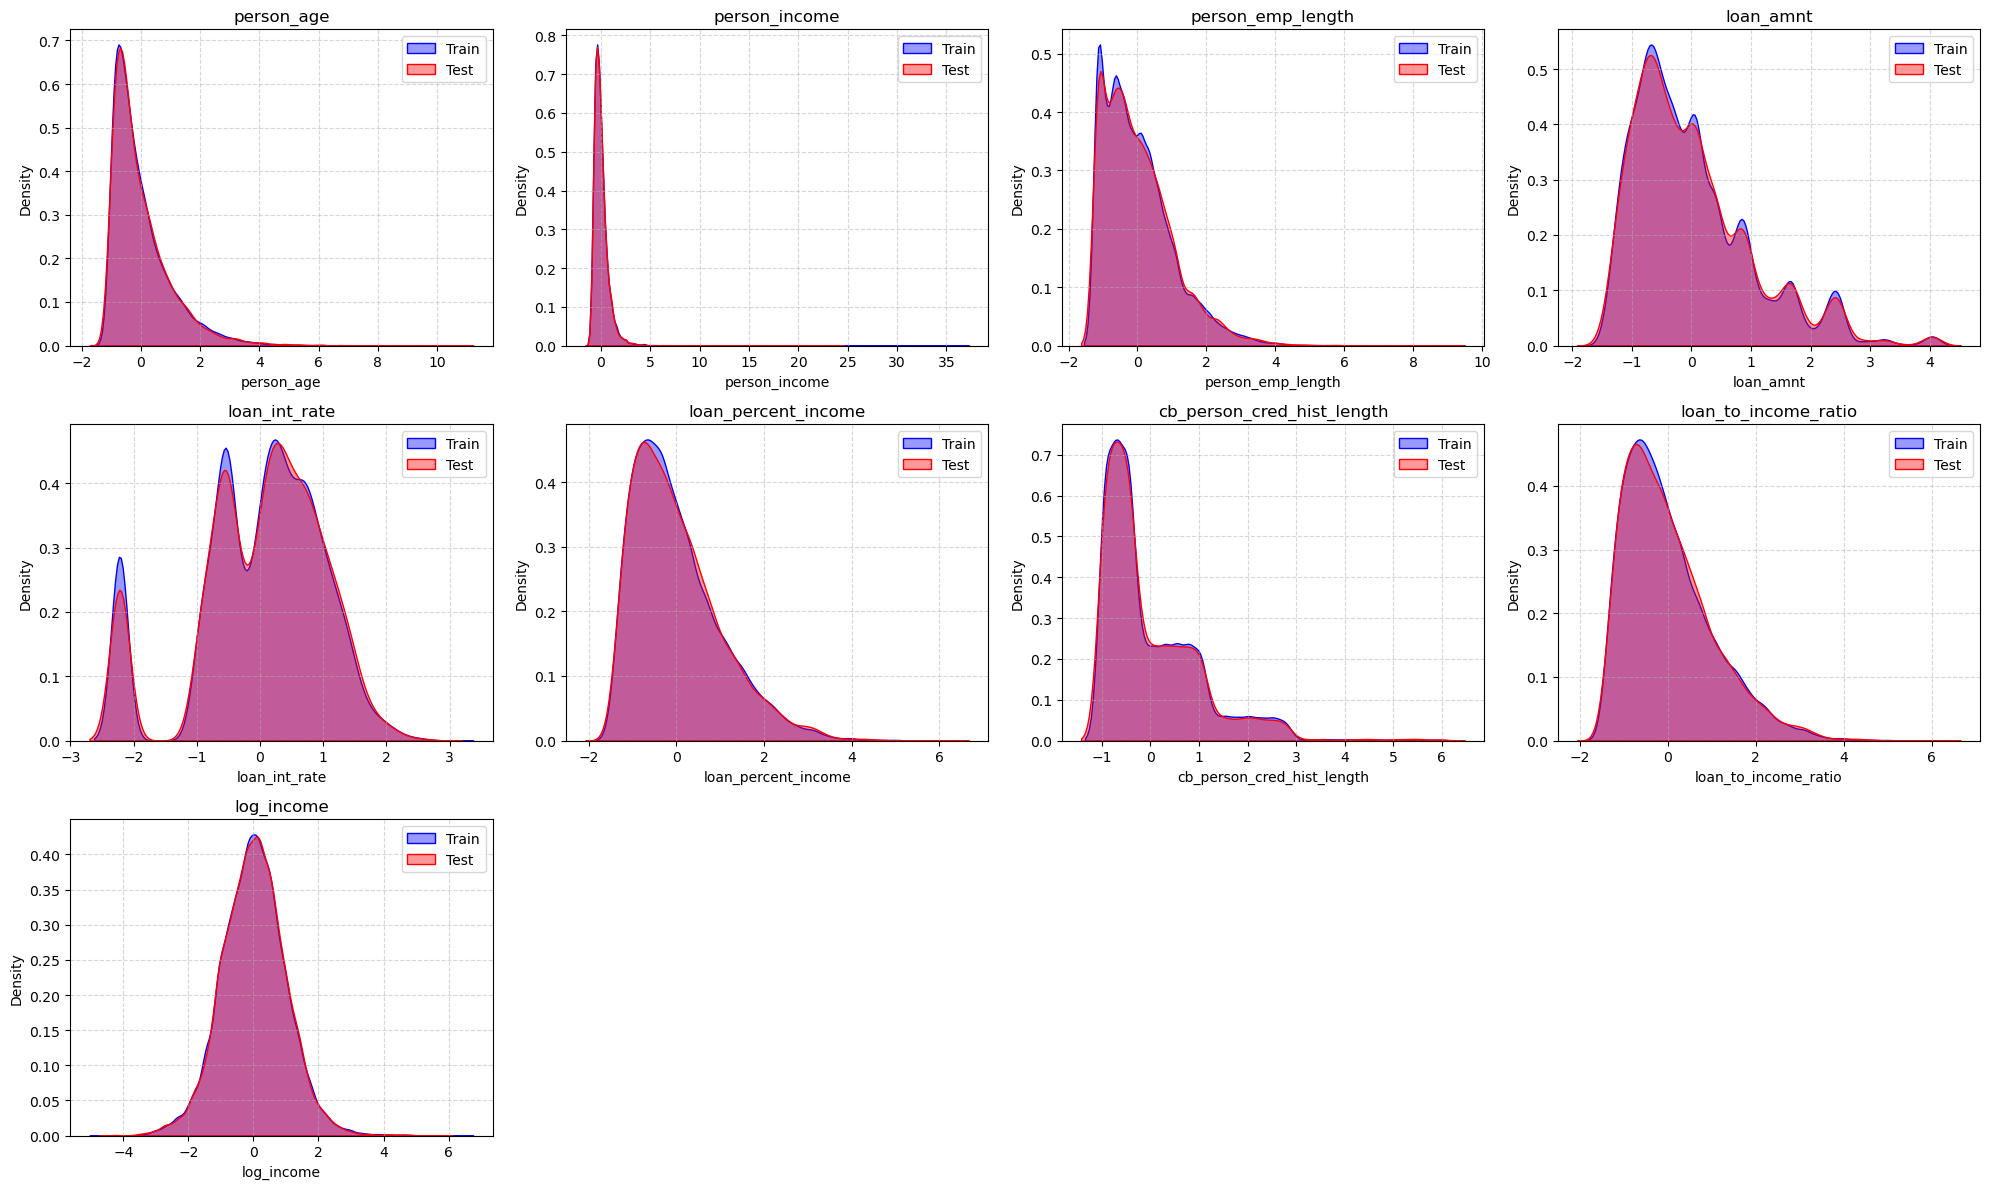

In [164]:
kde_nums(train_scaled, test_scaled)

In [165]:
evaluate_dataset(train_scaled, test_scaled, 'SCALED')

Fold: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]

---------- BASE ROC_AUC: 0.9474642686198895 ----------:



,Model,Dataset,Mean OOF ROC_AUC,ROC_AUC,Accuracy Score,Precision Score,Recall Score,f1 Score,Matthews Corr Coef,iteration_time
0,BASE,SCALED,0.947579,0.947464,0.9375,0.9395,0.9375,0.9343,0.811,0.772029


##### Scaling 2

In [175]:
def scale2(train_, test_, target_col='TARGET'):
    """
    Scales numeric features using mean and std from training data only.
    Restores categorical columns to 'category' dtype.
    
    Parameters:
    - train_: training DataFrame (must contain target_col)
    - test_: test DataFrame
    - target_col: name of target column in train (default = 'TARGET')

    Returns:
    - scaled_train: train with standardized numeric features
    - scaled_test: test with same scaling
    """
    # Safe copies
    train = train_.copy()
    test = test_.copy()

    # Get features based on training set only
    _, cat_cols, num_cols = fcn(test)

    # Standardize numeric features using train-only stats
    for col in num_cols:
        print(col, ', ', end='')
        mean = train[col].mean()
        std = train[col].std()

        # Apply standardization
        train[col] = (train[col] - mean) / std
        test[col] = (test[col] - mean) / std

        # Fill any resulting NaNs with 0 (e.g., if std = 0)
        train[col] = train[col].fillna(0)
        test[col] = test[col].fillna(0)

    # Restore categorical dtypes
    for col in cat_cols:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')

    # Return test with same feature set (excluding target)
    feature_cols = [col for col in train.columns if col != target_col]
    return train, test[feature_cols]


In [170]:
train_encoded.dtypes

person_age                       int64
person_income                    int64
person_home_ownership         category
person_emp_length              float64
loan_intent                   category
loan_grade                    category
loan_amnt                        int64
loan_int_rate                  float64
loan_percent_income            float64
cb_person_default_on_file     category
cb_person_cred_hist_length       int64
loan_status                   category
loan_to_income_ratio           float64
log_income                     float64
dtype: object

In [176]:
train_scaled2, test_scaled2 = scale2(train_encoded, test_encoded, target_col= TARGET)


person_age , person_income , person_emp_length , loan_amnt , loan_int_rate , loan_percent_income , cb_person_cred_hist_length , loan_to_income_ratio , log_income , 

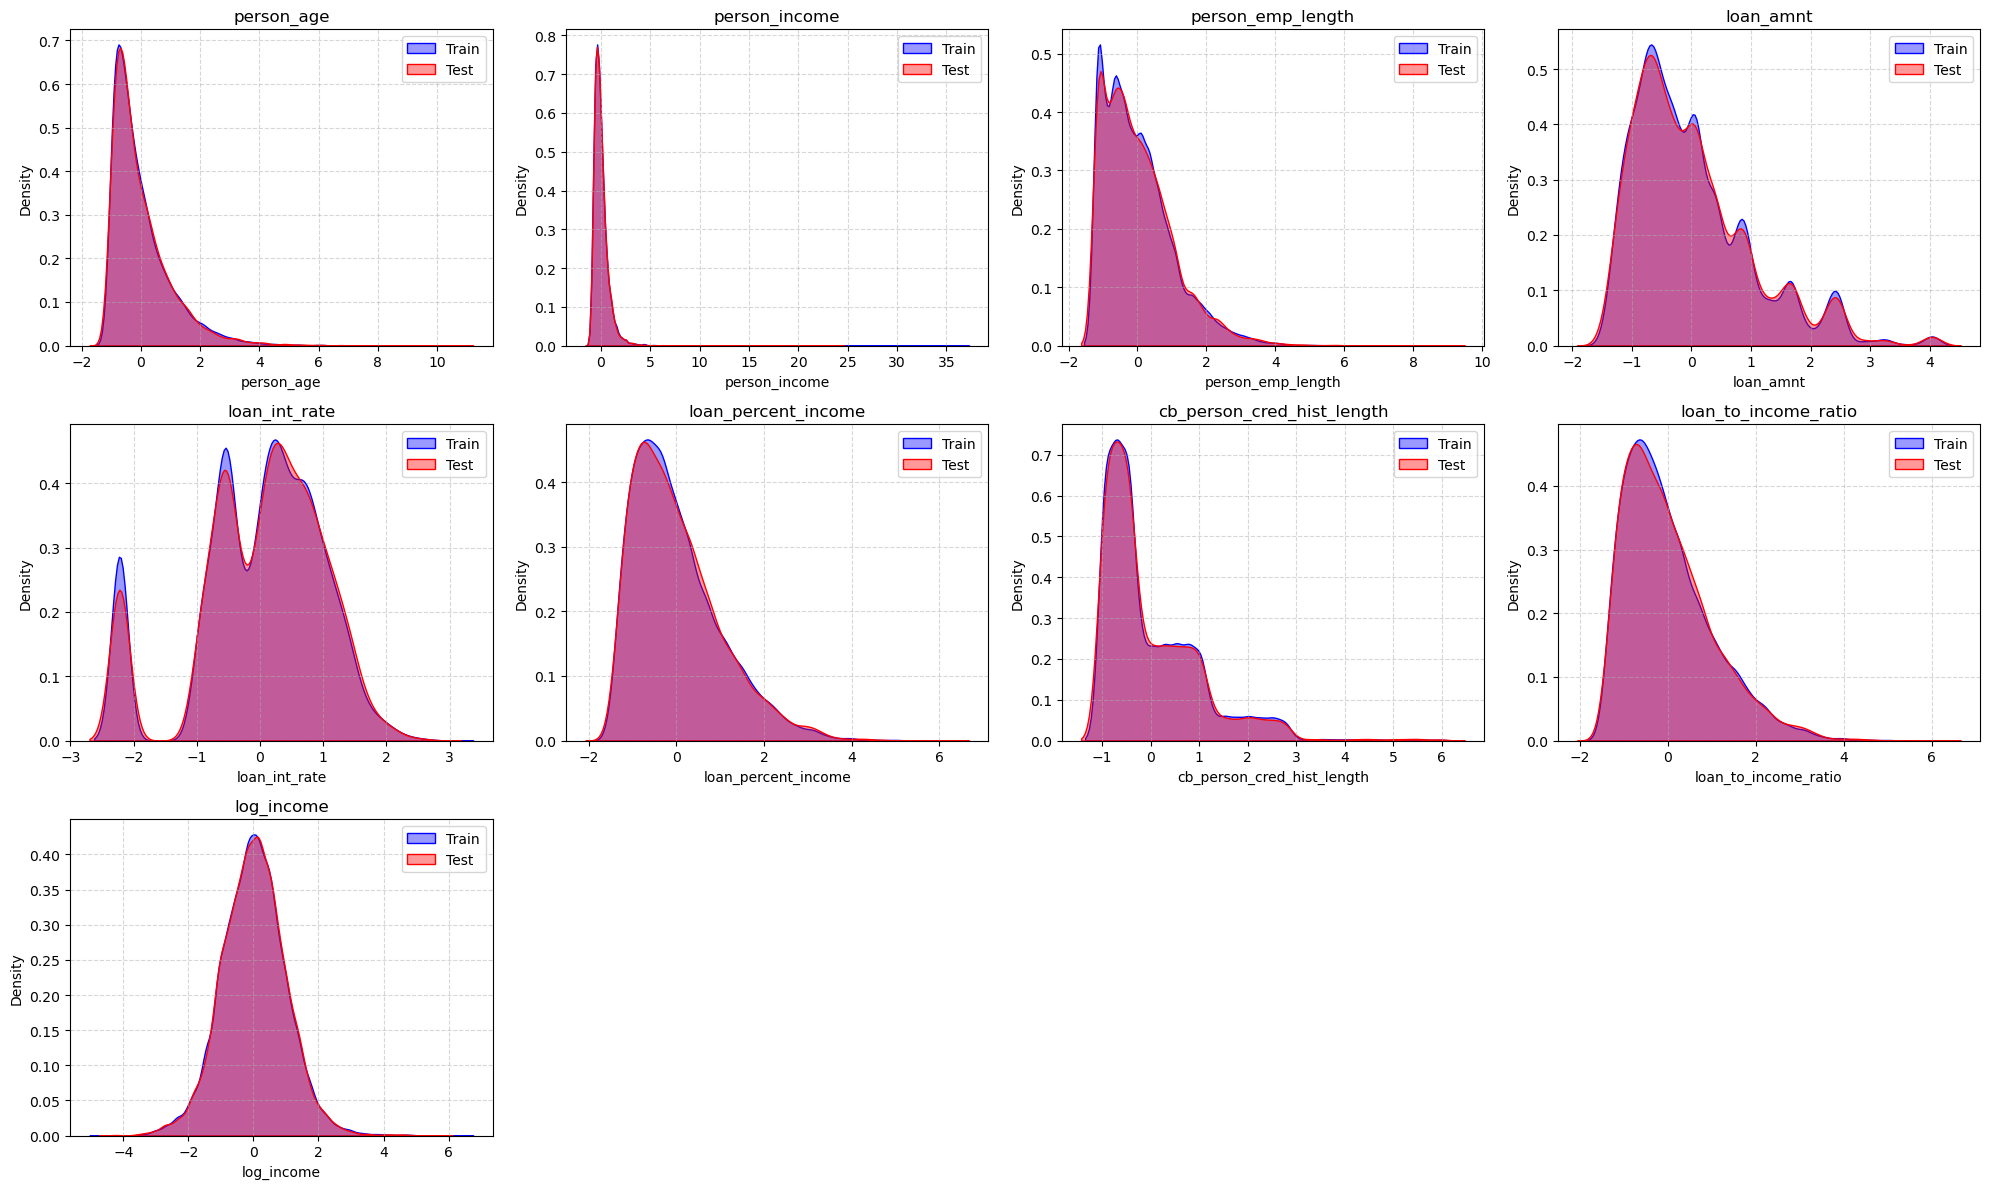

In [177]:
kde_nums(train_scaled2, test_scaled2)


In [178]:
evaluate_dataset(train_scaled2, test_scaled2, 'SCALED 2')

Fold: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

---------- BASE ROC_AUC: 0.9474811624362093 ----------:



,Model,Dataset,Mean OOF ROC_AUC,ROC_AUC,Accuracy Score,Precision Score,Recall Score,f1 Score,Matthews Corr Coef,iteration_time
0,BASE,SCALED 2,0.947597,0.947481,0.9375,0.9395,0.9375,0.9342,0.8108,0.718258
